In [148]:
import geopandas as gpd
import pandas as pd
import pygris
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import matplotlib
from tqdm.notebook import tqdm
import osmnx as ox
import contextily as cx
import json

plt.rcParams["figure.figsize"] = [8, 8]
matplotlib.rcParams['figure.dpi'] = 300

### Download PM 2.5 hyperlocal measurements from MIT-Seansable City

In [149]:
urls = [
    f"https://raw.githubusercontent.com/MIT-Senseable-City-Lab/OSCS/main/Explore/Datasets/NYC_Pilot2_PM_Part{i}.csv"
    for i in [1, 2, 3]
]

info = {
    "target": "pm25",
    "lat": "latitude",
    "lon": "longitude",
    "time": "time",
    "time_input_format": "unix",
    "time_zone": "US/Eastern",
    "features": ["temperature", "humidity"],
    "ids": ["SensorID"],
}

# download the three datasets
pts = []
for url in urls:
    chunk = pd.read_csv(url)
    pts.append(chunk)
pts = pd.concat(pts, ignore_index=True)

# convert the time column to local time
pts["time"] = pd.to_datetime(pts[info["time"]], unit="s")
pts["time"] = pts["time"].dt.tz_localize("UTC").dt.tz_convert(info["time_zone"])

# filter columns
cols = (
    info["ids"]
    + [info["time"], info["lon"], info["lat"], info["target"]]
    + info["features"]
)
pts = pts[cols]

# rename lon/lat columns
pts = pts.rename(columns={info["lon"]: "lon", info["lat"]: "lat"})

display(pts)

SensorID                      time        lon        lat      pm25  \
0       NYCP2_CS01A 2021-09-10 08:35:04-04:00 -73.869316  40.847672  4.508813   
1       NYCP2_CS01A 2021-09-10 08:35:08-04:00 -73.869316  40.847668  5.462420   
2       NYCP2_CS01A 2021-09-10 08:35:13-04:00 -73.869362  40.847649  5.154881   
3       NYCP2_CS01A 2021-09-10 08:35:18-04:00 -73.869362  40.847649  4.508813   
4       NYCP2_CS01A 2021-09-10 08:35:23-04:00 -73.869362  40.847649  5.539503   
...             ...                       ...        ...        ...       ...   
515912  NYCP2_CS05A 2021-09-24 07:04:30-04:00 -73.870689  40.845146  5.005314   
515913  NYCP2_CS05A 2021-09-24 07:04:35-04:00 -73.870689  40.845150  3.534440   
515914  NYCP2_CS05A 2021-09-24 07:04:40-04:00 -73.870689  40.845146  5.444739   
515915  NYCP2_CS05A 2021-09-24 07:04:45-04:00 -73.870697  40.845139  3.432193   
515916  NYCP2_CS05A 2021-09-24 07:04:50-04:00 -73.870697  40.845135  2.895179   

        temperature  humidity  
0              23.7      57.3  
1              23.7      57.8  
2              23.7      57.8  
3              23.6      57.6  
4              23.6      57.5  
...             ...       ...  
515912        -17.5       0.0  
515913        -17.5       0.0  
515914        -17.5       0.0  
515915        -17.5       0.0  
515916        -17.5       0.0  

[515917 rows x 7 columns]

### Coarsen points / keep polygons that contain points

In [150]:
# projection useful throughout
wgs84 = "EPSG:4326"  # unit is degrees
mercator = "EPSG:3857"  # unit is meters, useful for meter computations

#  ==== RANK 0: POINTS ====
# to reduce dim by aggregating measurements by time and location
delta_s = 0.0003 # 0.0001 deg ~ 11m
delta_t = "15min"
pts["lon"] = delta_s * np.round(pts.lon / delta_s)
pts["lat"] = delta_s * np.round(pts.lat / delta_s)
pts["time"] = pts.time.dt.round(delta_t, ambiguous="NaT")
# keep only time of day not date and weekday
pts["time"], pts["weekday"] = pts.time.dt.time, pts.time.dt.weekday
group_cols = ["time", "weekday", "lon", "lat"]
value_cols = ["temperature", "humidity", "pm25"]
pts = pts.groupby(group_cols)[value_cols].median().reset_index()
pts["weekday"] = pts["weekday"].astype(int)

# convert to geopandas
geom = gpd.points_from_xy(pts.lon, pts.lat, crs=wgs84)
pts = gpd.GeoDataFrame(pts, geometry=geom)
print("Processed points")
display(pts)

# ==== RANK 1: ROADS =====
roads = pygris.roads(state="NY", county="Bronx").to_crs(wgs84)
print("Roads")
display(roads)

# ==== RANK 2: TRACTS ====
tracts = pygris.tracts(
    state="NY", county="Bronx", year=2020, cache=True, cb=True
).to_crs(wgs84)
tracts["TRACTCE"] = tracts["TRACTCE"].astype(int)
tracts.set_index("TRACTCE", inplace=True)
print("Tracts")
display(tracts)

Processed points


time  weekday      lon      lat  temperature  humidity      pm25  \
0       00:00:00        0 -73.8711  40.8447         9.20     62.50  3.827015   
1       00:00:00        0 -73.8705  40.8456        17.65     54.45  4.488808   
2       00:00:00        0 -73.8705  40.8471        18.20     52.20  4.647728   
3       00:00:00        0 -73.8702  40.8465        17.70     53.60  4.663546   
4       00:00:00        0 -73.8702  40.8468        17.80     53.20  4.689192   
...          ...      ...      ...      ...          ...       ...       ...   
107083  23:45:00        6 -73.8669  40.8477         6.80     68.00  2.267851   
107084  23:45:00        6 -73.8666  40.8462         7.10     65.10  2.267851   
107085  23:45:00        6 -73.8666  40.8465         7.00     65.80  2.267851   
107086  23:45:00        6 -73.8663  40.8453         7.70     62.80  2.267851   
107087  23:45:00        6 -73.8663  40.8456         7.20     64.80  2.267851   

                          geometry  
0       POINT (-73.87110 40.84470)  
1       POINT (-73.87050 40.84560)  
2       POINT (-73.87050 40.84710)  
3       POINT (-73.87020 40.84650)  
4       POINT (-73.87020 40.84680)  
...                            ...  
107083  POINT (-73.86690 40.84770)  
107084  POINT (-73.86660 40.84620)  
107085  POINT (-73.86660 40.84650)  
107086  POINT (-73.86630 40.84530)  
107087  POINT (-73.86630 40.84560)  

[107088 rows x 8 columns]

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '005' for input 'Bronx'
Roads


LINEARID             FULLNAME RTTYP  MTFCC  \
0      1104691956808       Bryant Ave Ovp     M  S1710   
1       110391525903     Putnam Ave W Exd     M  S1400   
2       110391524230       E 177th St Exd     M  S1400   
3       110391523610          5th Ave Exd     M  S1400   
4       110391528344  Cross Bx Svc Rd Exd     O  S1640   
...              ...                  ...   ...    ...   
3348  11012812945824                 None  None  S1780   
3349    110391526368           Dogwood Dr     M  S1400   
3350  11012812959297                 None  None  S1710   
3351    110391527948           Spencer Pl     M  S1400   
3352   1103717136086           McLean Ave     M  S1400   

                                               geometry  
0     LINESTRING (-73.88891 40.82181, -73.88857 40.8...  
1     LINESTRING (-73.90028 40.88302, -73.90014 40.8...  
2     LINESTRING (-73.80205 40.81721, -73.80117 40.8...  
3     LINESTRING (-73.81216 40.82314, -73.81230 40.8...  
4     LINESTRING (-73.88568 40.84051, -73.88492 40.8...  
...                                                 ...  
3348  LINESTRING (-73.86609 40.82136, -73.86542 40.8...  
3349  LINESTRING (-73.86176 40.84151, -73.86127 40.8...  
3350  LINESTRING (-73.86081 40.84048, -73.86076 40.8...  
3351  LINESTRING (-73.89812 40.91180, -73.89742 40.9...  
3352  LINESTRING (-73.86264 40.90147, -73.86256 40.9...  

[3353 rows x 5 columns]

Using FIPS code '36' for input 'NY'
Using FIPS code '005' for input 'Bronx'
Tracts


STATEFP COUNTYFP              AFFGEOID        GEOID    NAME  \
TRACTCE                                                               
9200         36      005  1400000US36005009200  36005009200      92   
6400         36      005  1400000US36005006400  36005006400      64   
36501        36      005  1400000US36005036501  36005036501  365.01   
7900         36      005  1400000US36005007900  36005007900      79   
24700        36      005  1400000US36005024700  36005024700     247   
...         ...      ...                   ...          ...     ...   
42500        36      005  1400000US36005042500  36005042500     425   
7300         36      005  1400000US36005007300  36005007300      73   
15100        36      005  1400000US36005015100  36005015100     151   
40501        36      005  1400000US36005040501  36005040501  405.01   
27600        36      005  1400000US36005027600  36005027600     276   

                    NAMELSAD STUSPS    NAMELSADCO STATE_NAME LSAD    ALAND  \
TRACTCE                                                                      
9200         Census Tract 92     NY  Bronx County   New York   CT   310475   
6400         Census Tract 64     NY  Bronx County   New York   CT   167185   
36501    Census Tract 365.01     NY  Bronx County   New York   CT    95827   
7900         Census Tract 79     NY  Bronx County   New York   CT   197933   
24700       Census Tract 247     NY  Bronx County   New York   CT   149162   
...                      ...    ...           ...        ...  ...      ...   
42500       Census Tract 425     NY  Bronx County   New York   CT   293818   
7300         Census Tract 73     NY  Bronx County   New York   CT   140161   
15100       Census Tract 151     NY  Bronx County   New York   CT   208933   
40501    Census Tract 405.01     NY  Bronx County   New York   CT    82860   
27600       Census Tract 276     NY  Bronx County   New York   CT  1837997   

         AWATER                                           geometry  
TRACTCE                                                             
9200          0  POLYGON ((-73.86034 40.83329, -73.85906 40.833...  
6400          0  POLYGON ((-73.87395 40.83424, -73.87380 40.835...  
36501         0  POLYGON ((-73.88832 40.84518, -73.88776 40.844...  
7900          0  POLYGON ((-73.90822 40.81620, -73.90759 40.816...  
24700         0  POLYGON ((-73.92096 40.85511, -73.92000 40.856...  
...         ...                                                ...  
42500         0  POLYGON ((-73.88362 40.86726, -73.88184 40.868...  
7300          0  POLYGON ((-73.91194 40.81605, -73.91102 40.815...  
15100         0  POLYGON ((-73.90227 40.82964, -73.90025 40.831...  
40501         0  POLYGON ((-73.89330 40.86529, -73.89250 40.866...  
27600    499778  POLYGON ((-73.83282 40.85612, -73.83199 40.856...  

[361 rows x 13 columns]

Keep only valid points/roads/tracts that interesect

In [151]:
 # ==== KEEP ONLY THE VALID POINTS =====
 
# obtain pts to road_map with 5m buffer
geom = roads.geometry.to_crs(mercator).buffer(5).to_crs(wgs84)
road_buff = gpd.GeoDataFrame(geometry=geom)
sjoin1 = gpd.sjoin(pts, road_buff, predicate="within", how="inner")
valid_pts1 = sjoin1.index.unique()

geom = tracts.geometry.to_crs(mercator).buffer(5).to_crs(wgs84)
tract_buff = gpd.GeoDataFrame(geometry=geom)
sjoin2 = gpd.sjoin(pts, tract_buff, predicate="within", how="inner")
valid_pts2 = sjoin2.index.unique()

valid_pts = list(set(valid_pts1) & set(valid_pts2))

# subset valid points, roads, and tracts
pts = pts.loc[valid_pts]
sjoin1 = sjoin1.loc[sjoin1.index.isin(valid_pts)]
sjoin2 = sjoin2.loc[sjoin2.index.isin(valid_pts)]
valid_roads = sjoin1.index_right.unique()
valid_tracts = sjoin2.index_right.unique()
sjoin1 = sjoin1.loc[sjoin1.index_right.isin(valid_roads)]
sjoin2 = sjoin2.loc[sjoin2.index_right.isin(valid_tracts)]
roads = roads.loc[valid_roads]
roads_buff = road_buff.loc[valid_roads]
tracts = tracts.loc[valid_tracts]
tract_buff = tract_buff.loc[valid_tracts]

# reset the indexes
ixmap_pts = {k: i for i, k in enumerate(pts.index)}
ixmap_roads = {k: i for i, k in enumerate(roads.index)}
ixmap_tracts = {k: i for i, k in enumerate(tracts.index)}

## we actually want to keep the original indices for matching information
## except for pts, in which it doesn't make sense

print("Final set of points")
display(pts)

print("Final set of roads")
display(roads)

print("Final set of tracts")
display(tracts)

/Users/mag7273/mambaforge/envs/spatial-data-processing/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


Final set of points


/Users/mag7273/mambaforge/envs/spatial-data-processing/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


time  weekday      lon      lat  temperature  humidity      pm25  \
11      00:00:00        0 -73.8696  40.8474        18.35     51.35  4.566492   
16      00:00:00        0 -73.8690  40.8480        18.50     51.10  4.648553   
18      00:00:00        1 -73.8918  40.8192        24.20     47.45  7.608064   
19      00:00:00        1 -73.8915  40.8195        24.20     47.60  3.876476   
20      00:00:00        1 -73.8912  40.8198        24.20     47.70  3.891000   
...          ...      ...      ...      ...          ...       ...       ...   
107070  23:45:00        6 -73.8696  40.8474         6.50     74.10  2.309777   
107073  23:45:00        6 -73.8690  40.8480         6.50     73.65  2.267851   
107078  23:45:00        6 -73.8678  40.8489         6.70     71.70  2.267851   
107085  23:45:00        6 -73.8666  40.8465         7.00     65.80  2.267851   
107087  23:45:00        6 -73.8663  40.8456         7.20     64.80  2.267851   

                          geometry  
11      POINT (-73.86960 40.84740)  
16      POINT (-73.86900 40.84800)  
18      POINT (-73.89180 40.81920)  
19      POINT (-73.89150 40.81950)  
20      POINT (-73.89120 40.81980)  
...                            ...  
107070  POINT (-73.86960 40.84740)  
107073  POINT (-73.86900 40.84800)  
107078  POINT (-73.86780 40.84890)  
107085  POINT (-73.86660 40.84650)  
107087  POINT (-73.86630 40.84560)  

[34482 rows x 8 columns]

Final set of roads


LINEARID         FULLNAME RTTYP  MTFCC  \
1762    110391528204     Birchall Ave     M  S1400   
919    1105083214580    Bruckner Blvd     M  S1400   
538    1105083214583    Bruckner Blvd     M  S1400   
3012  11013782384108           I- 278     I  S1100   
3013  11013782383882    Bruckner Expy     M  S1100   
...              ...              ...   ...    ...   
1038   1104699295549             None  None  S1630   
1899    110391533095             None  None  S1710   
3074    110391529986  Country Club Rd     M  S1400   
916    1105083217024             None  None  S1630   
1617   1105083217028             None  None  S1630   

                                               geometry  
1762  LINESTRING (-73.86782 40.84990, -73.86837 40.8...  
919   LINESTRING (-73.90635 40.80750, -73.90596 40.8...  
538   LINESTRING (-73.90635 40.80750, -73.90609 40.8...  
3012  LINESTRING (-73.91905 40.79899, -73.91893 40.7...  
3013  LINESTRING (-73.91739 40.80125, -73.91713 40.8...  
...                                                 ...  
1038  LINESTRING (-73.83006 40.86205, -73.82965 40.8...  
1899  LINESTRING (-73.82492 40.83890, -73.82498 40.8...  
3074  LINESTRING (-73.82624 40.84299, -73.82581 40.8...  
916   LINESTRING (-73.82734 40.85940, -73.82737 40.8...  
1617  LINESTRING (-73.82734 40.85940, -73.82740 40.8...  

[692 rows x 5 columns]

Final set of tracts


STATEFP COUNTYFP              AFFGEOID        GEOID    NAME  \
TRACTCE                                                               
33400        36      005  1400000US36005033400  36005033400     334   
22000        36      005  1400000US36005022000  36005022000     220   
9301         36      005  1400000US36005009301  36005009301   93.01   
11502        36      005  1400000US36005011502  36005011502  115.02   
11900        36      005  1400000US36005011900  36005011900     119   
...         ...      ...                   ...          ...     ...   
31400        36      005  1400000US36005031400  36005031400     314   
16000        36      005  1400000US36005016000  36005016000     160   
13800        36      005  1400000US36005013800  36005013800     138   
11800        36      005  1400000US36005011800  36005011800     118   
31000        36      005  1400000US36005031000  36005031000     310   

                    NAMELSAD STUSPS    NAMELSADCO STATE_NAME LSAD    ALAND  \
TRACTCE                                                                      
33400       Census Tract 334     NY  Bronx County   New York   CT  3067606   
22000       Census Tract 220     NY  Bronx County   New York   CT   228610   
9301      Census Tract 93.01     NY  Bronx County   New York   CT   570768   
11502    Census Tract 115.02     NY  Bronx County   New York   CT   336295   
11900       Census Tract 119     NY  Bronx County   New York   CT   166999   
...                      ...    ...           ...        ...  ...      ...   
31400       Census Tract 314     NY  Bronx County   New York   CT   211194   
16000       Census Tract 160     NY  Bronx County   New York   CT   494499   
13800       Census Tract 138     NY  Bronx County   New York   CT   765354   
11800       Census Tract 118     NY  Bronx County   New York   CT   989676   
31000       Census Tract 310     NY  Bronx County   New York   CT   639444   

          AWATER                                           geometry  
TRACTCE                                                              
33400      39710  POLYGON ((-73.88386 40.86519, -73.88362 40.865...  
22000          0  POLYGON ((-73.87836 40.84000, -73.87686 40.842...  
9301           0  POLYGON ((-73.89543 40.81584, -73.89514 40.816...  
11502      10032  POLYGON ((-73.89082 40.82031, -73.88965 40.821...  
11900          0  POLYGON ((-73.89200 40.82472, -73.89139 40.824...  
...          ...                                                ...  
31400          0  POLYGON ((-73.84732 40.86097, -73.84726 40.862...  
16000    2614648  POLYGON ((-73.82334 40.83441, -73.82264 40.834...  
13800    3460009  POLYGON ((-73.81914 40.82235, -73.81615 40.821...  
11800    2876319  POLYGON ((-73.81637 40.81759, -73.81545 40.817...  
31000          0  POLYGON ((-73.84093 40.85933, -73.84082 40.862...  

[188 rows x 13 columns]

In [152]:
print("length if valid points", len(valid_pts))
print("length if valid roads", len(valid_roads))
print("length if valid tracts", len(valid_tracts))

# print max of ixmap keys
print("max of ixmap_pts", max(ixmap_pts.values()))
print("max of ixmap_roads", max(ixmap_roads.values()))
print("max of ixmap_tracts", max(ixmap_tracts.values()))

length if valid points 34482
length if valid roads 692
length if valid tracts 188
max of ixmap_pts 34481
max of ixmap_roads 691
max of ixmap_tracts 187


### Crosswalks (adjacencies cross-rank)

Create cells

In [153]:
cell_0 = [[i] for i in range(len(pts))]
cell_1 = [[] for _ in range(len(roads))]
map_0_1 = [None] * len(pts)
map_0_2 = [None] * len(pts)

for ix, row in sjoin1.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_roads[row["index_right"]]
    cell_1[dst].append(src)
    map_0_1[src] = dst

cell_2 = [[] for _ in range(len(tracts))]
for ix, row in sjoin2.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_tracts[row["index_right"]]
    cell_2[dst].append(src)
    map_0_2[src] = dst

pts["road"] = map_0_1
pts["tract"] = map_0_2
print("Augmented cols")
display(pts[["road", "tract"]])

# verify
print("Number of empty roads", sum(1 for c in cell_1 if not c))
print("Number of empty tracts", sum(1 for c in cell_2 if not c))
print("Number of unmapped points to road", sum(1 for m in map_0_1 if m is None))
print("Number of unmapped points to tract", sum(1 for m in map_0_2 if m is None))

Augmented cols


road  tract
11         0      0
16         0      0
18         1      2
19         1      2
20         1      2
...      ...    ...
107070     0      0
107073     0      0
107078    36     13
107085    14     44
107087    14     44

[34482 rows x 2 columns]

Number of empty roads 0
Number of empty tracts 0
Number of unmapped points to road 0
Number of unmapped points to tract 0


Number of edges pts -> road 40781
Number of edges road -> tract 1591


<Axes: >

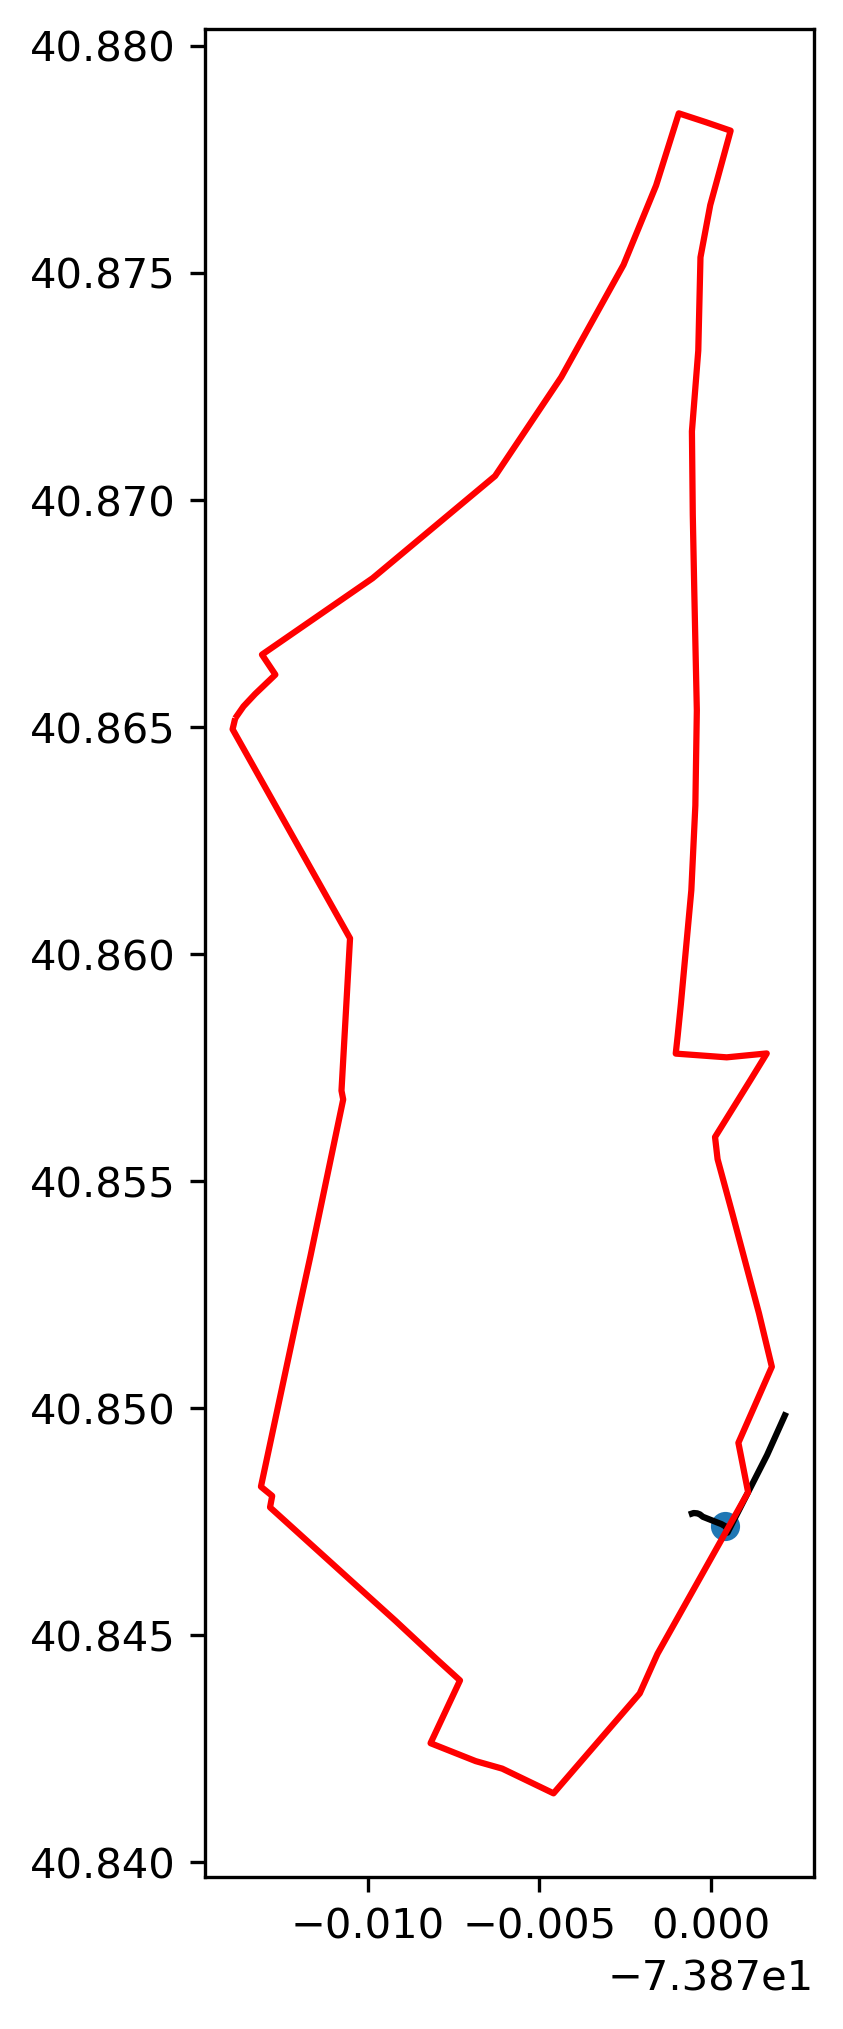

In [154]:
# === Incidences Rank 0 -> Rank 1 (used also as incidence(0, 1)) ====
edges_pts_road = set()
# for i, j in enumerate(map_0_1):
#     if j is not None:
#         edges_pts_road.append([i, j])
# point goes to a road if the road contains the point
for i in range(len(pts)):
    for j, c in enumerate(cell_1):
        if i in c:
            edges_pts_road.add((i, j))
edges_pts_road = list(edges_pts_road)
print("Number of edges pts -> road", len(edges_pts_road))

# === Incidences Rank 1 -> Rank 2 ====
# strategy: create neighbors if they road and tract share a point
edges_road_tract = set()
for i, road in enumerate(cell_1):
    for k, tract in enumerate(cell_2):
        if set(road) & set(tract):
            edges_road_tract.add((i, k))
edges_road_tract = list(edges_road_tract)
print("Number of edges road -> tract", len(edges_road_tract))

# map a point tract and road to verify
n = 1000
pt_n = pts.iloc[[n]]
road_n = roads.iloc[pt_n.road]
tract_n = tracts.iloc[pt_n.tract]
fig, ax = plt.subplots()
pt_n.plot(ax=ax)
road_n.plot(ax=ax, color="black")
tract_n.boundary.plot(ax=ax, color="red")

<Axes: >

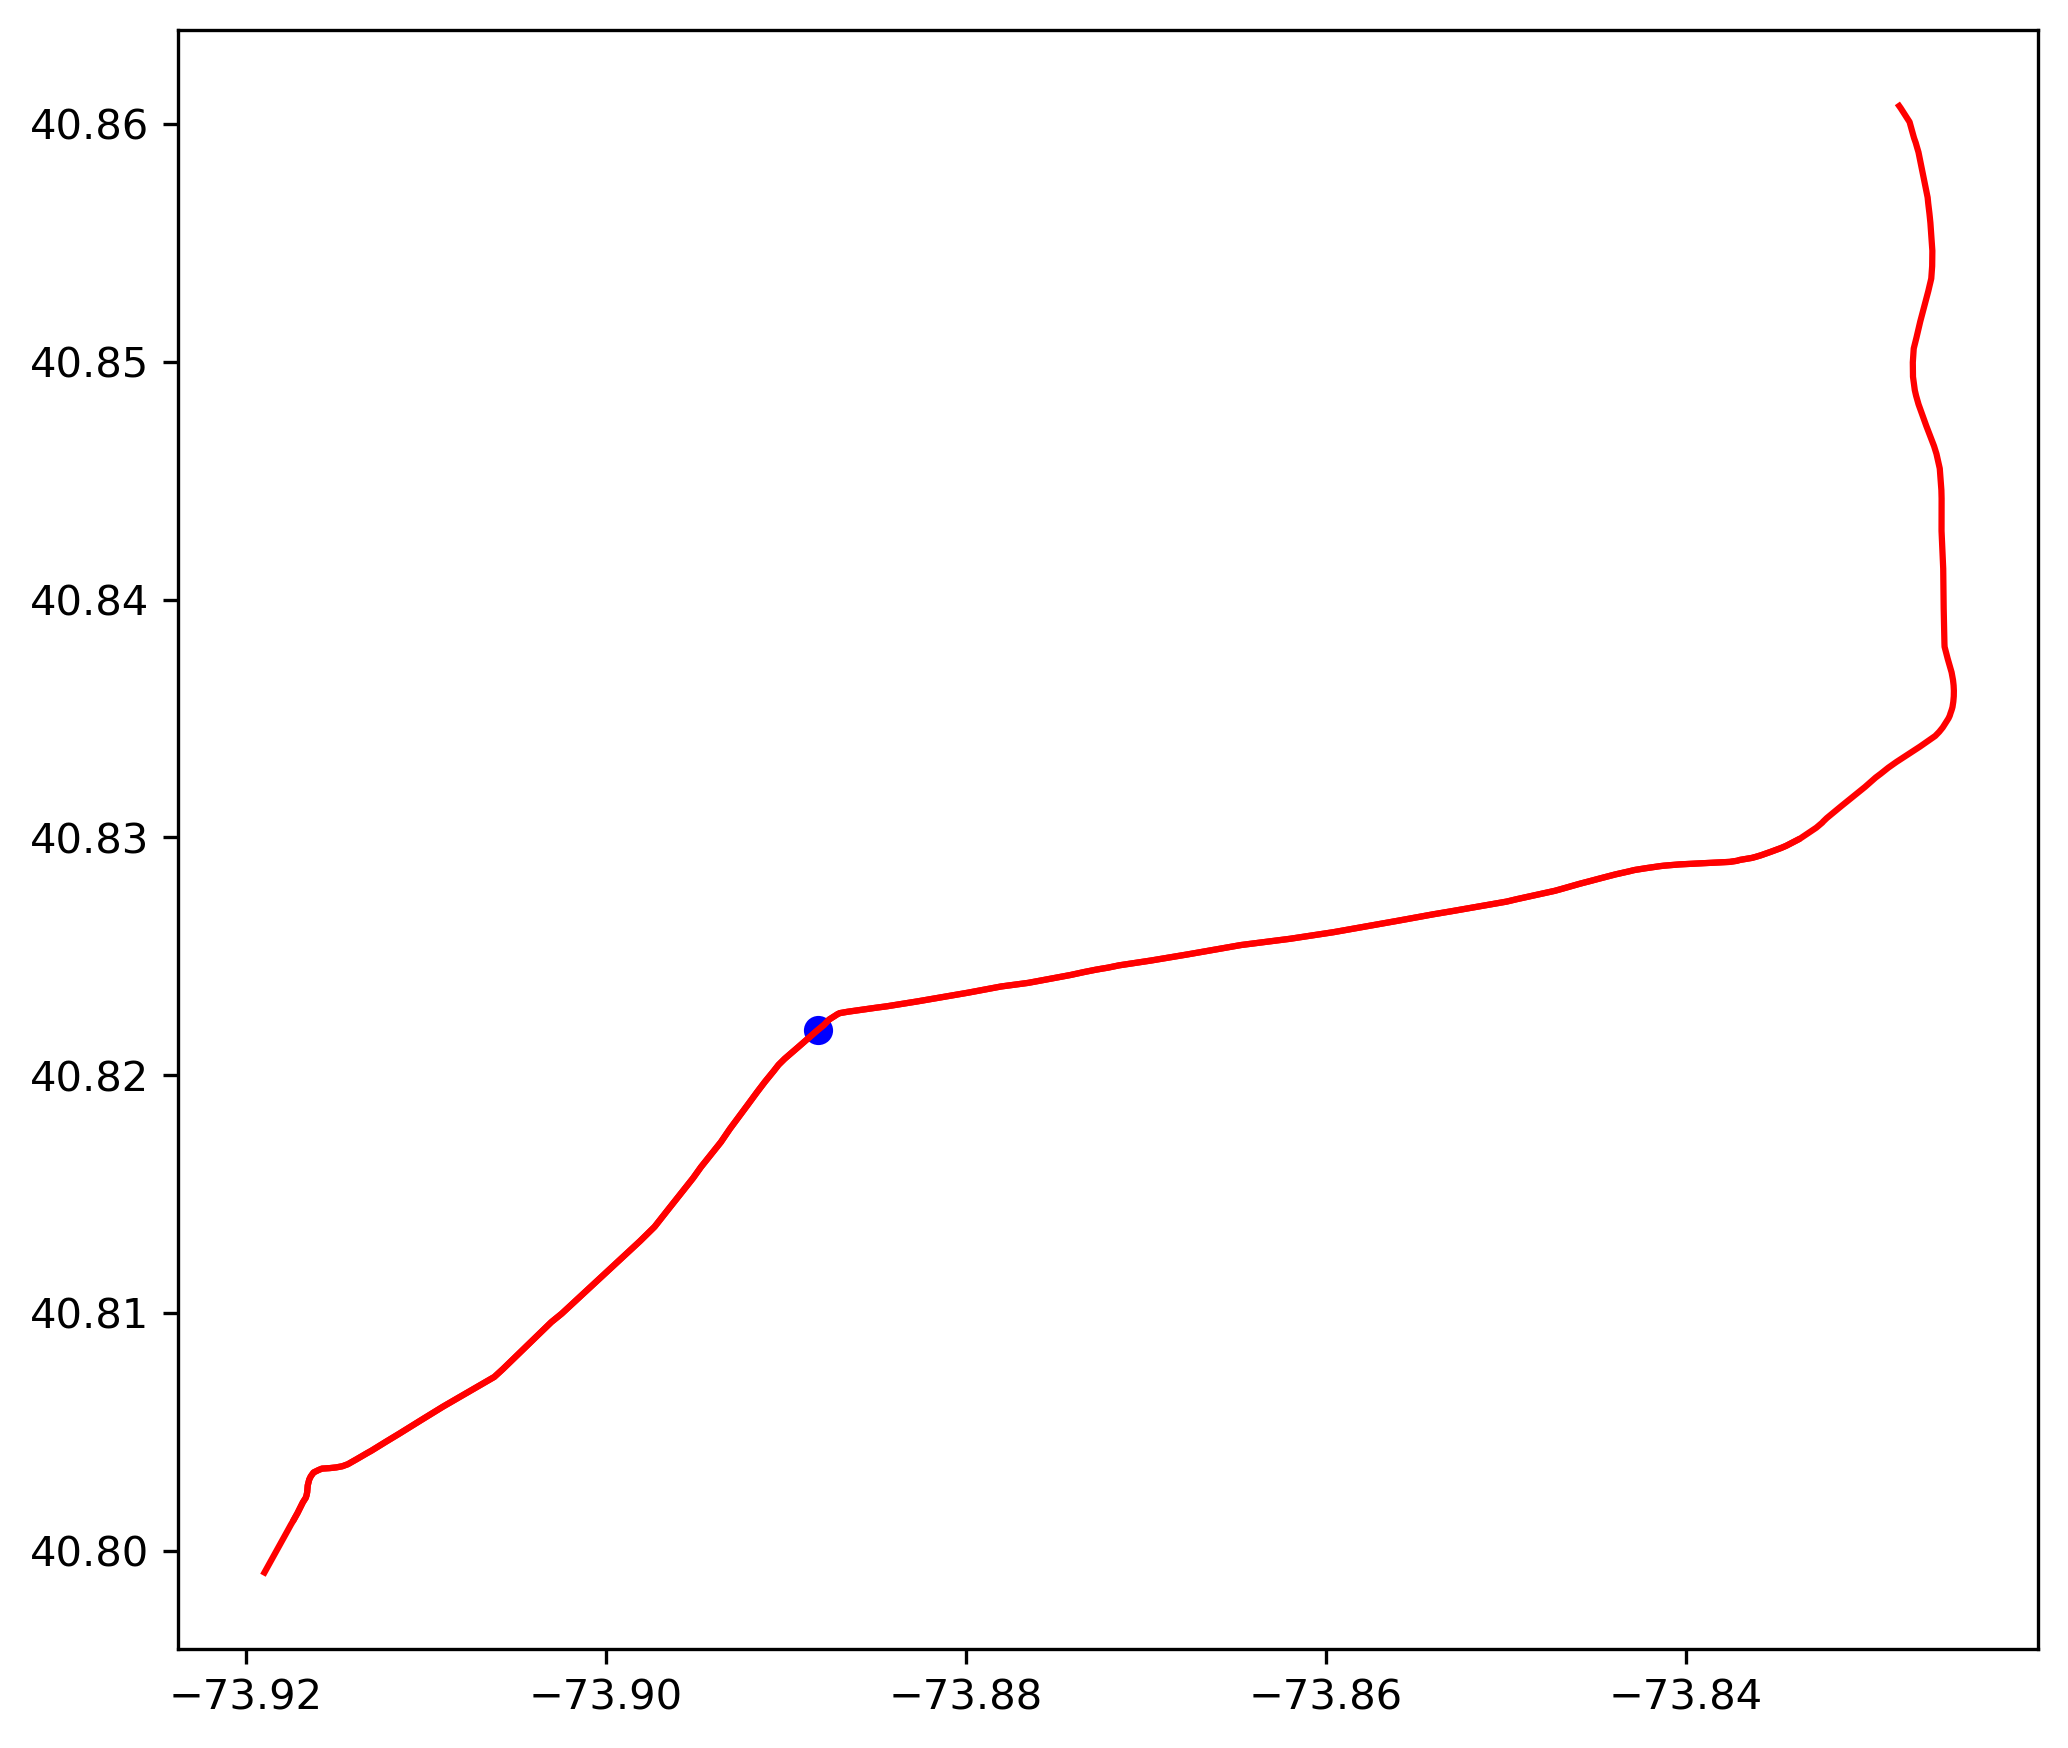

In [155]:
fig, ax = plt.subplots()
pt_n = 7
tgts = [e[1] for e in edges_pts_road if e[0] == pt_n]
p = pts.iloc[[pt_n]]
r = roads.iloc[tgts]
p.plot(ax=ax, color="blue")
r.plot(ax=ax, color="red")

<Axes: >

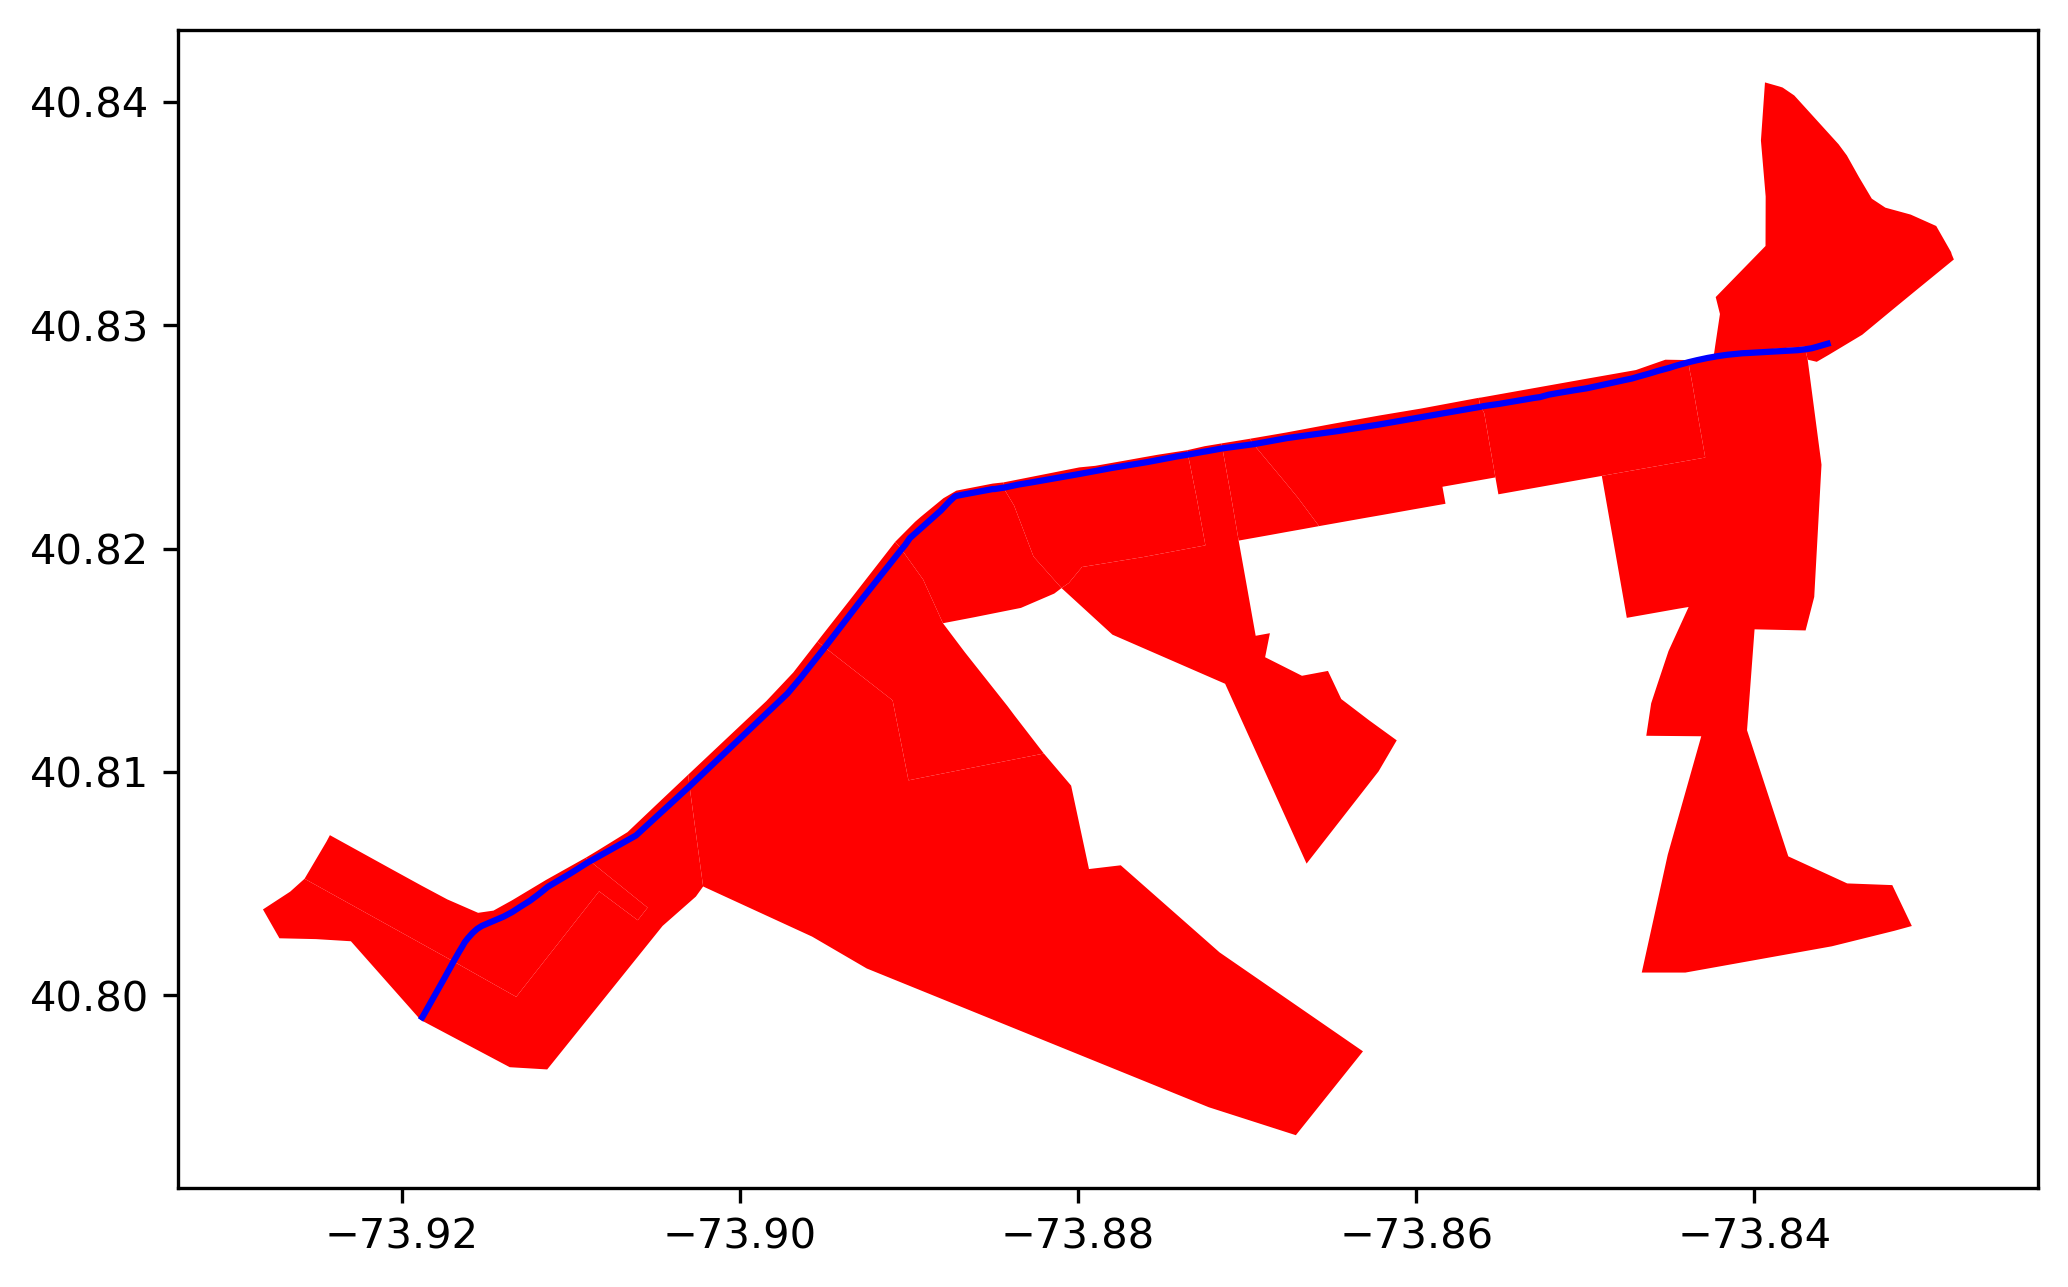

In [156]:
fig, ax = plt.subplots()
r_n = 7
tgts = [e[1] for e in edges_road_tract if e[0] == pt_n]
p = roads.iloc[[r_n]]
r = tracts.iloc[tgts]
p.plot(ax=ax, color="blue")
r.plot(ax=ax, color="red")

Road displayed 232


/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_33758/721658775.py:22: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  nbr_tracts.plot(
/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_33758/721658775.py:30: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  nbr_tracts.plot(


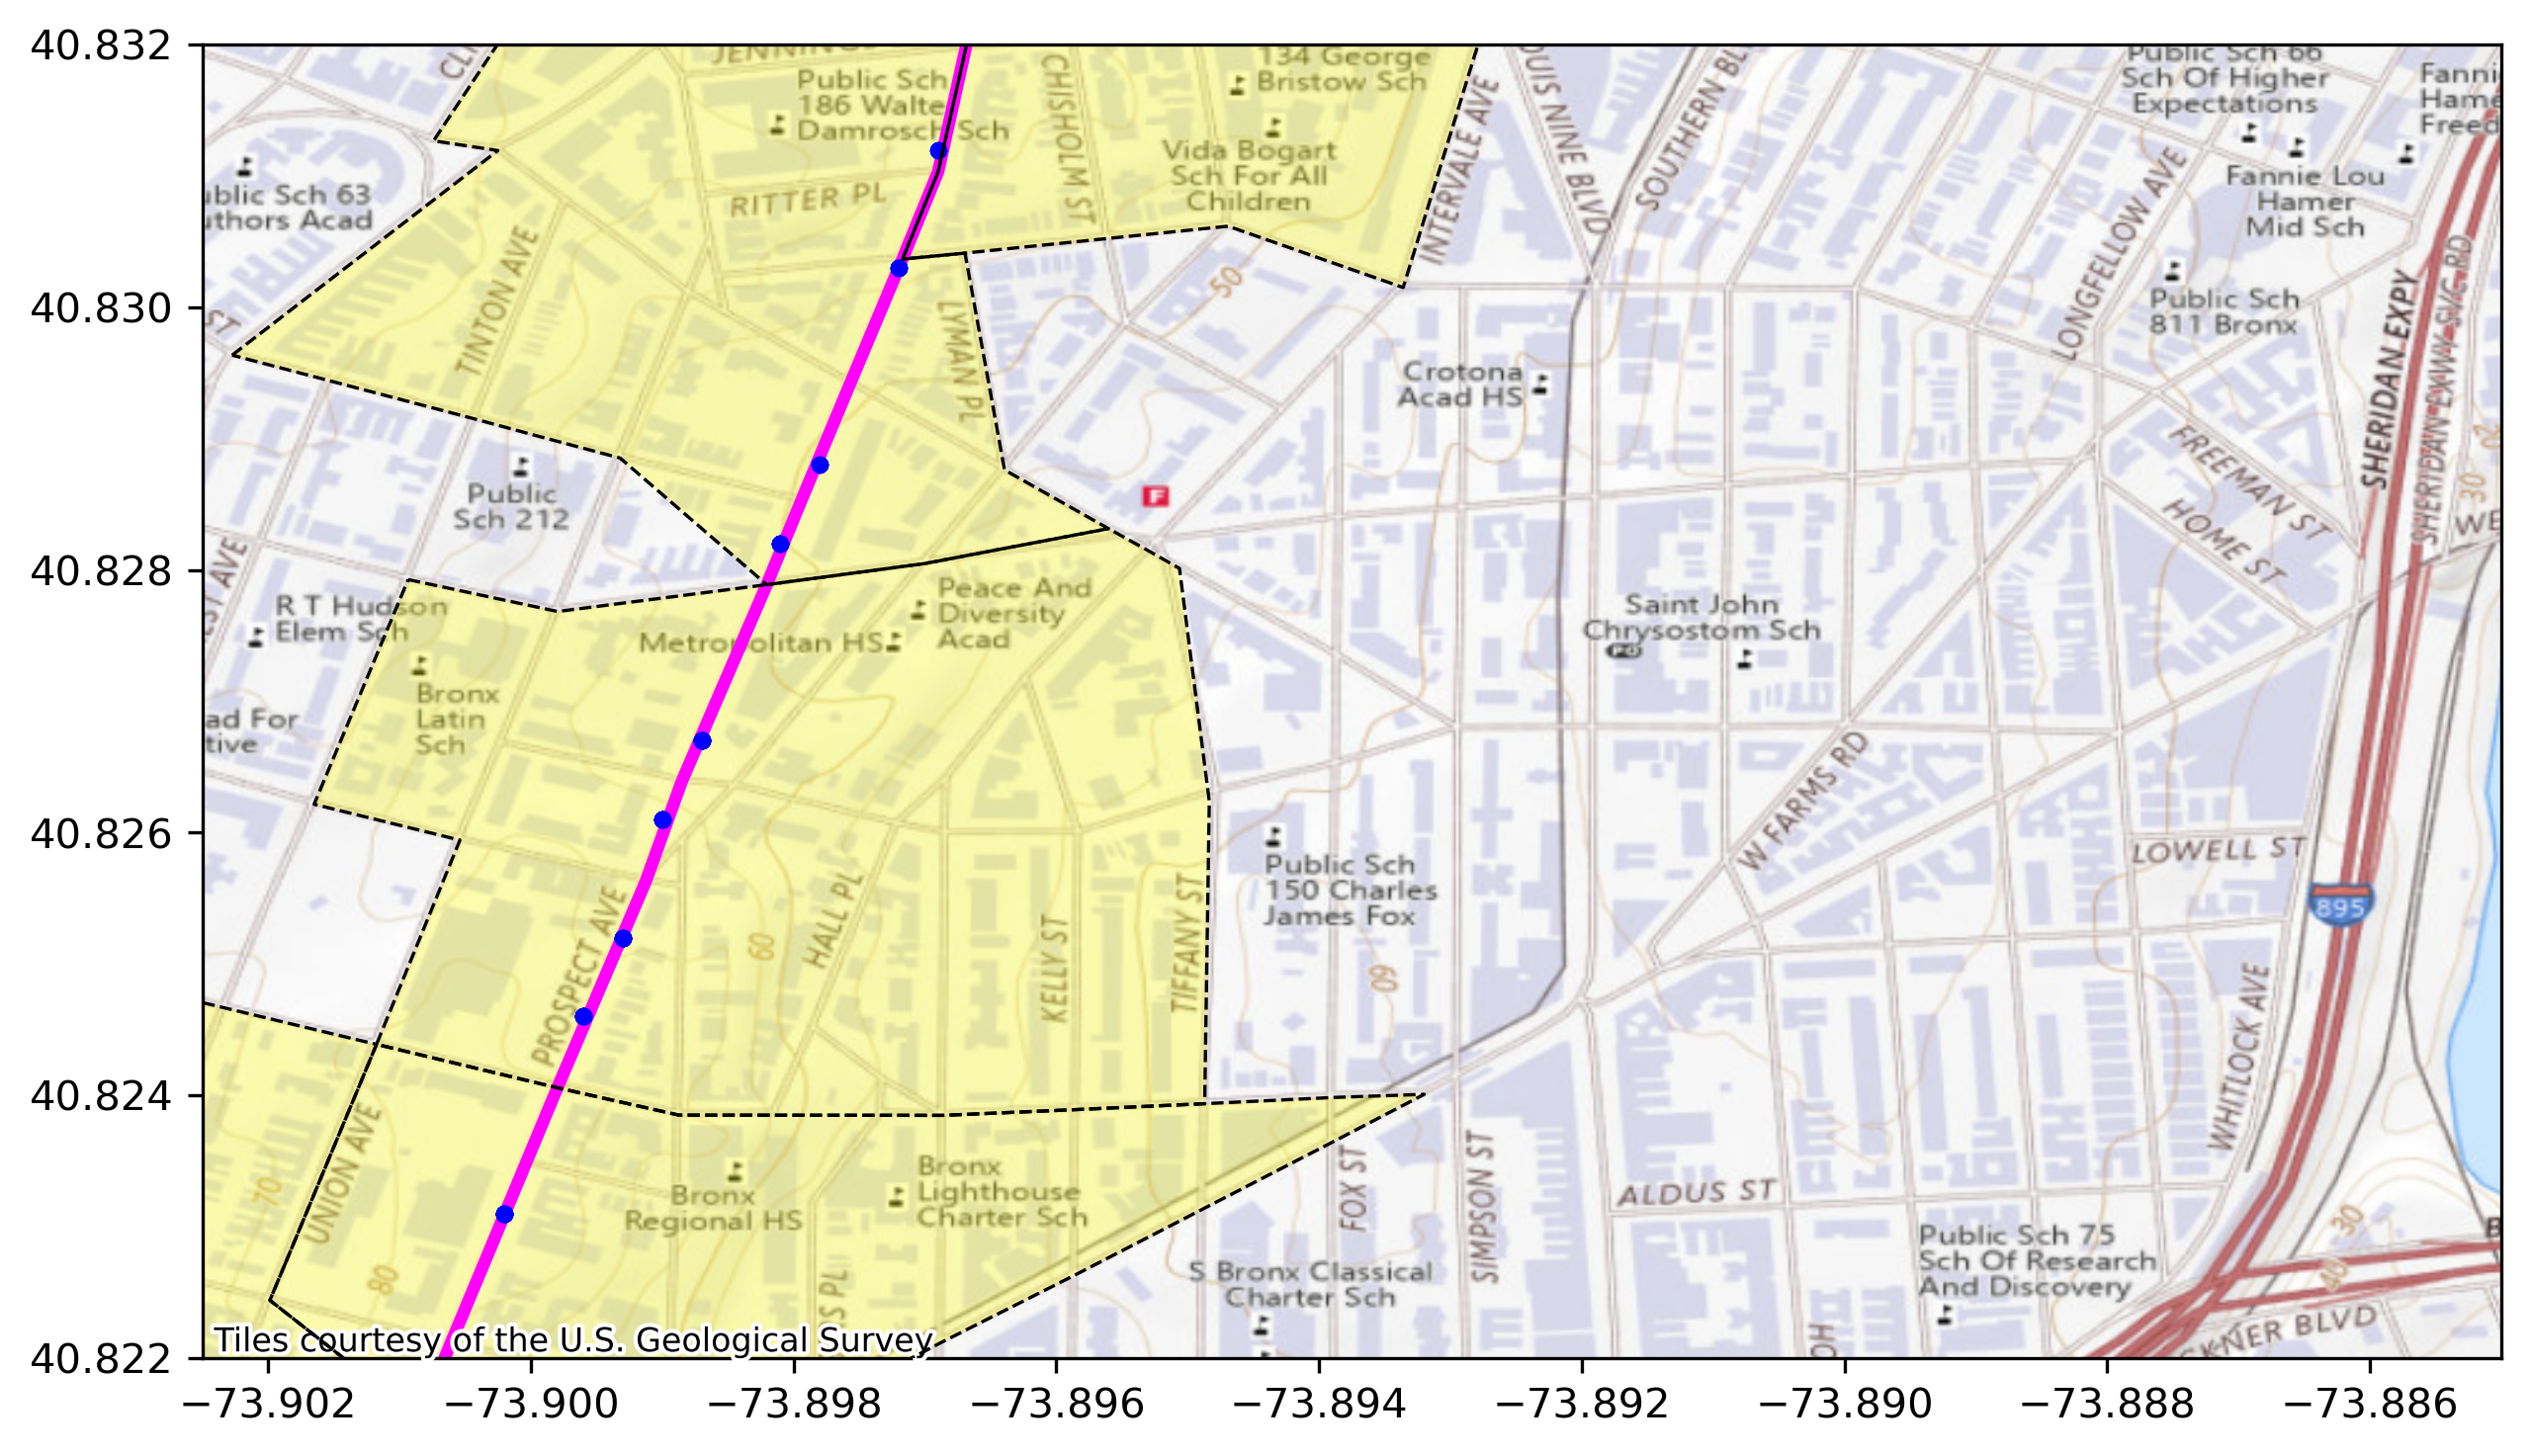

<Axes: >

In [157]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

#
road_counts = pd.Series([e[1] for e in edges_pts_road])
vc = road_counts.value_counts()
vc_k = vc.index[31]
print("Road displayed", vc_k)

#
tgt_pts = [e[0] for e in edges_pts_road if e[1] == vc_k]
tgt_roads = [vc_k]
tgt_tracts = [e[1] for e in edges_road_tract if e[0] == vc_k]


# Show an example
pts_k = pts.iloc[tgt_pts]
road_feats_k = roads.iloc[tgt_roads]
nbr_tracts = tracts.iloc[tgt_tracts]

# roads.plot(ax=ax, color="black", alpha=0.1)
# make fill collor always yello
nbr_tracts.plot(
    "id",
    alpha=0.3,
    lw=0.0,
    ls="--",
    color="yellow",
    ax=ax,
)
nbr_tracts.plot(
    "id",
    edgecolor="black",
    ls="--",
    alpha=1.0,
    lw=0.8,
    color="none",
    ax=ax,
    zorder=11
)
road_feats_k.plot(color="magenta", linewidth=3, ax=ax)
# ensure pts appear on top of other plots
pts_k.plot(markersize=10, ax=ax, c="blue", zorder=10)

# plt.title("Example of road intersecting tracts")


# make sure that the axis coordinates do not use scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-73.9025, -73.885)
plt.ylim(40.822, 40.832)
cx.add_basemap(ax, crs=tracts.crs, zoom=16, source=cx.providers.USGS.USTopo)
plt.show()

# save as png
fig.savefig("notebooks/spatial-cc-example.png", bbox_inches="tight")
ax

### Points

Visualize points/pm25

time  weekday      lon      lat  temperature  humidity      pm25  \
11      00:00:00        0 -73.8696  40.8474        18.35     51.35  4.566492   
16      00:00:00        0 -73.8690  40.8480        18.50     51.10  4.648553   
18      00:00:00        1 -73.8918  40.8192        24.20     47.45  7.608064   
19      00:00:00        1 -73.8915  40.8195        24.20     47.60  3.876476   
20      00:00:00        1 -73.8912  40.8198        24.20     47.70  3.891000   
...          ...      ...      ...      ...          ...       ...       ...   
107070  23:45:00        6 -73.8696  40.8474         6.50     74.10  2.309777   
107073  23:45:00        6 -73.8690  40.8480         6.50     73.65  2.267851   
107078  23:45:00        6 -73.8678  40.8489         6.70     71.70  2.267851   
107085  23:45:00        6 -73.8666  40.8465         7.00     65.80  2.267851   
107087  23:45:00        6 -73.8663  40.8456         7.20     64.80  2.267851   

                          geometry  road  tract  
11      POINT (-73.86960 40.84740)     0      0  
16      POINT (-73.86900 40.84800)     0      0  
18      POINT (-73.89180 40.81920)     1      2  
19      POINT (-73.89150 40.81950)     1      2  
20      POINT (-73.89120 40.81980)     1      2  
...                            ...   ...    ...  
107070  POINT (-73.86960 40.84740)     0      0  
107073  POINT (-73.86900 40.84800)     0      0  
107078  POINT (-73.86780 40.84890)    36     13  
107085  POINT (-73.86660 40.84650)    14     44  
107087  POINT (-73.86630 40.84560)    14     44  

[34482 rows x 10 columns]

<Axes: >

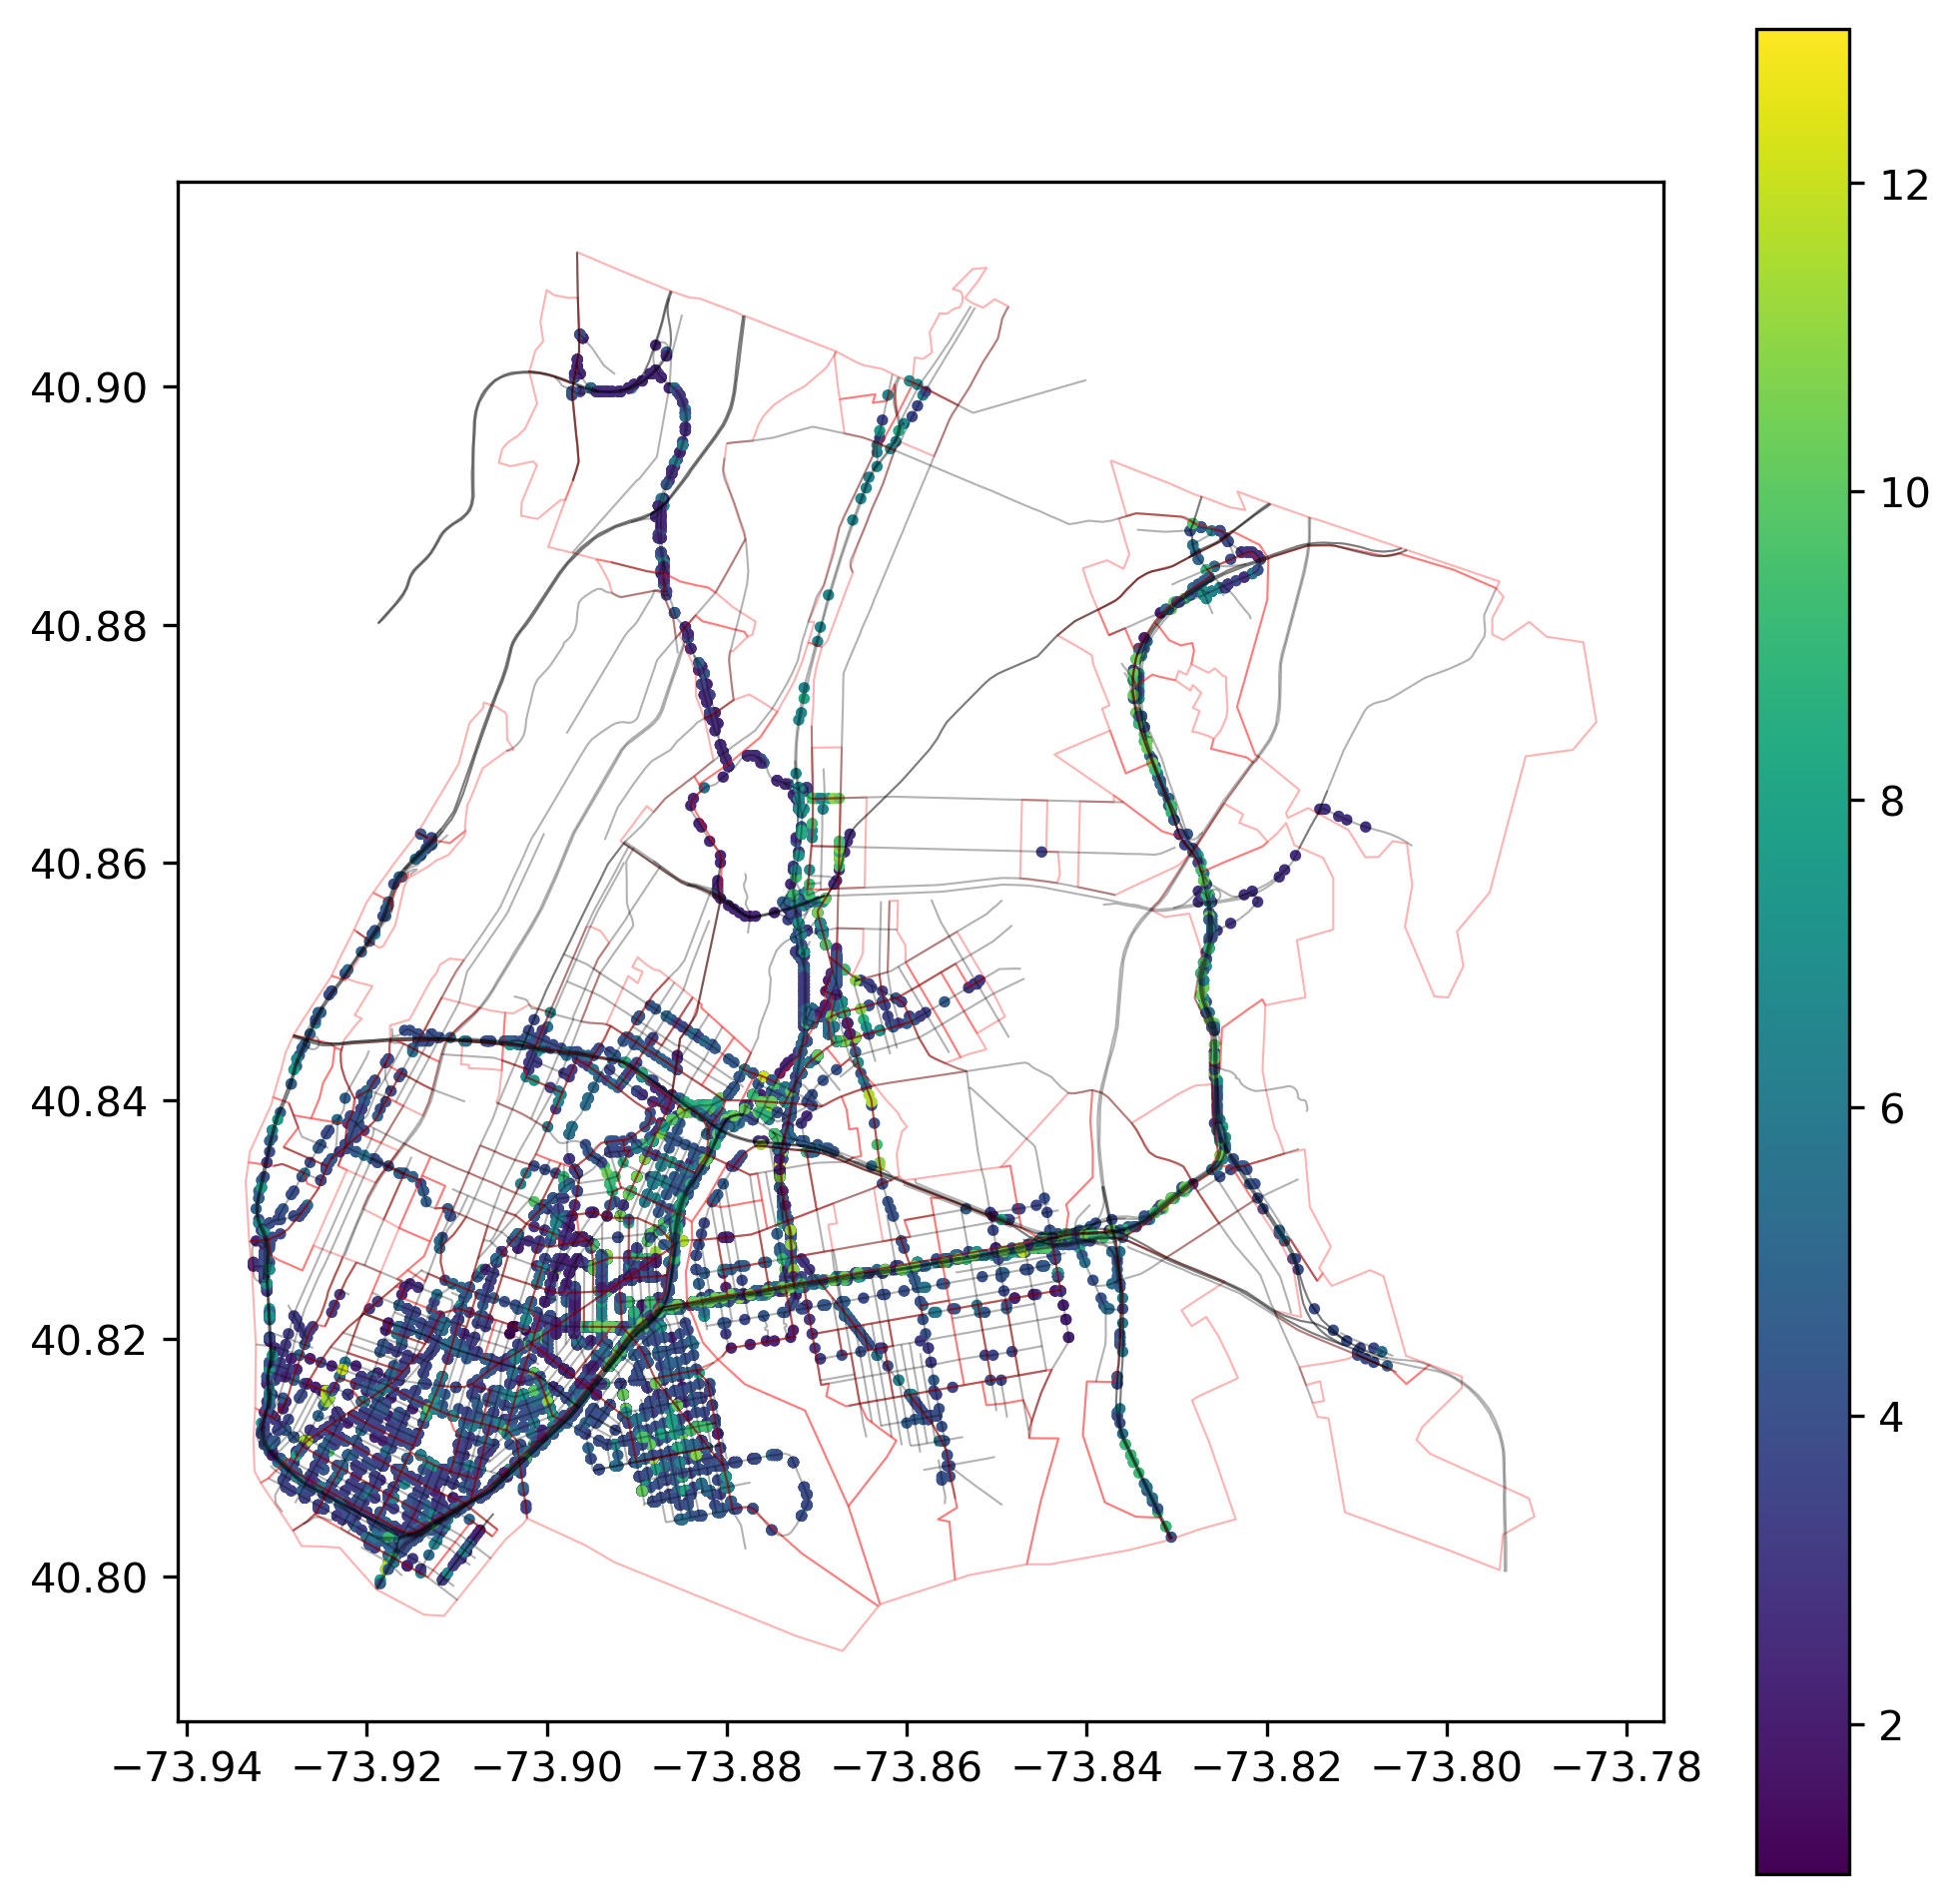

In [158]:
display(pts)
fig, ax = plt.subplots()
tracts.boundary.plot(edgecolor="red", linewidth=0.5, alpha=0.3, ax=ax)
roads.plot(color="black", linewidth=0.5, alpha=0.3, ax=ax)
pts.plot("pm25", legend=True, markersize=3, ax=ax)

Text(0.5, 1.0, 'Count of points per road')

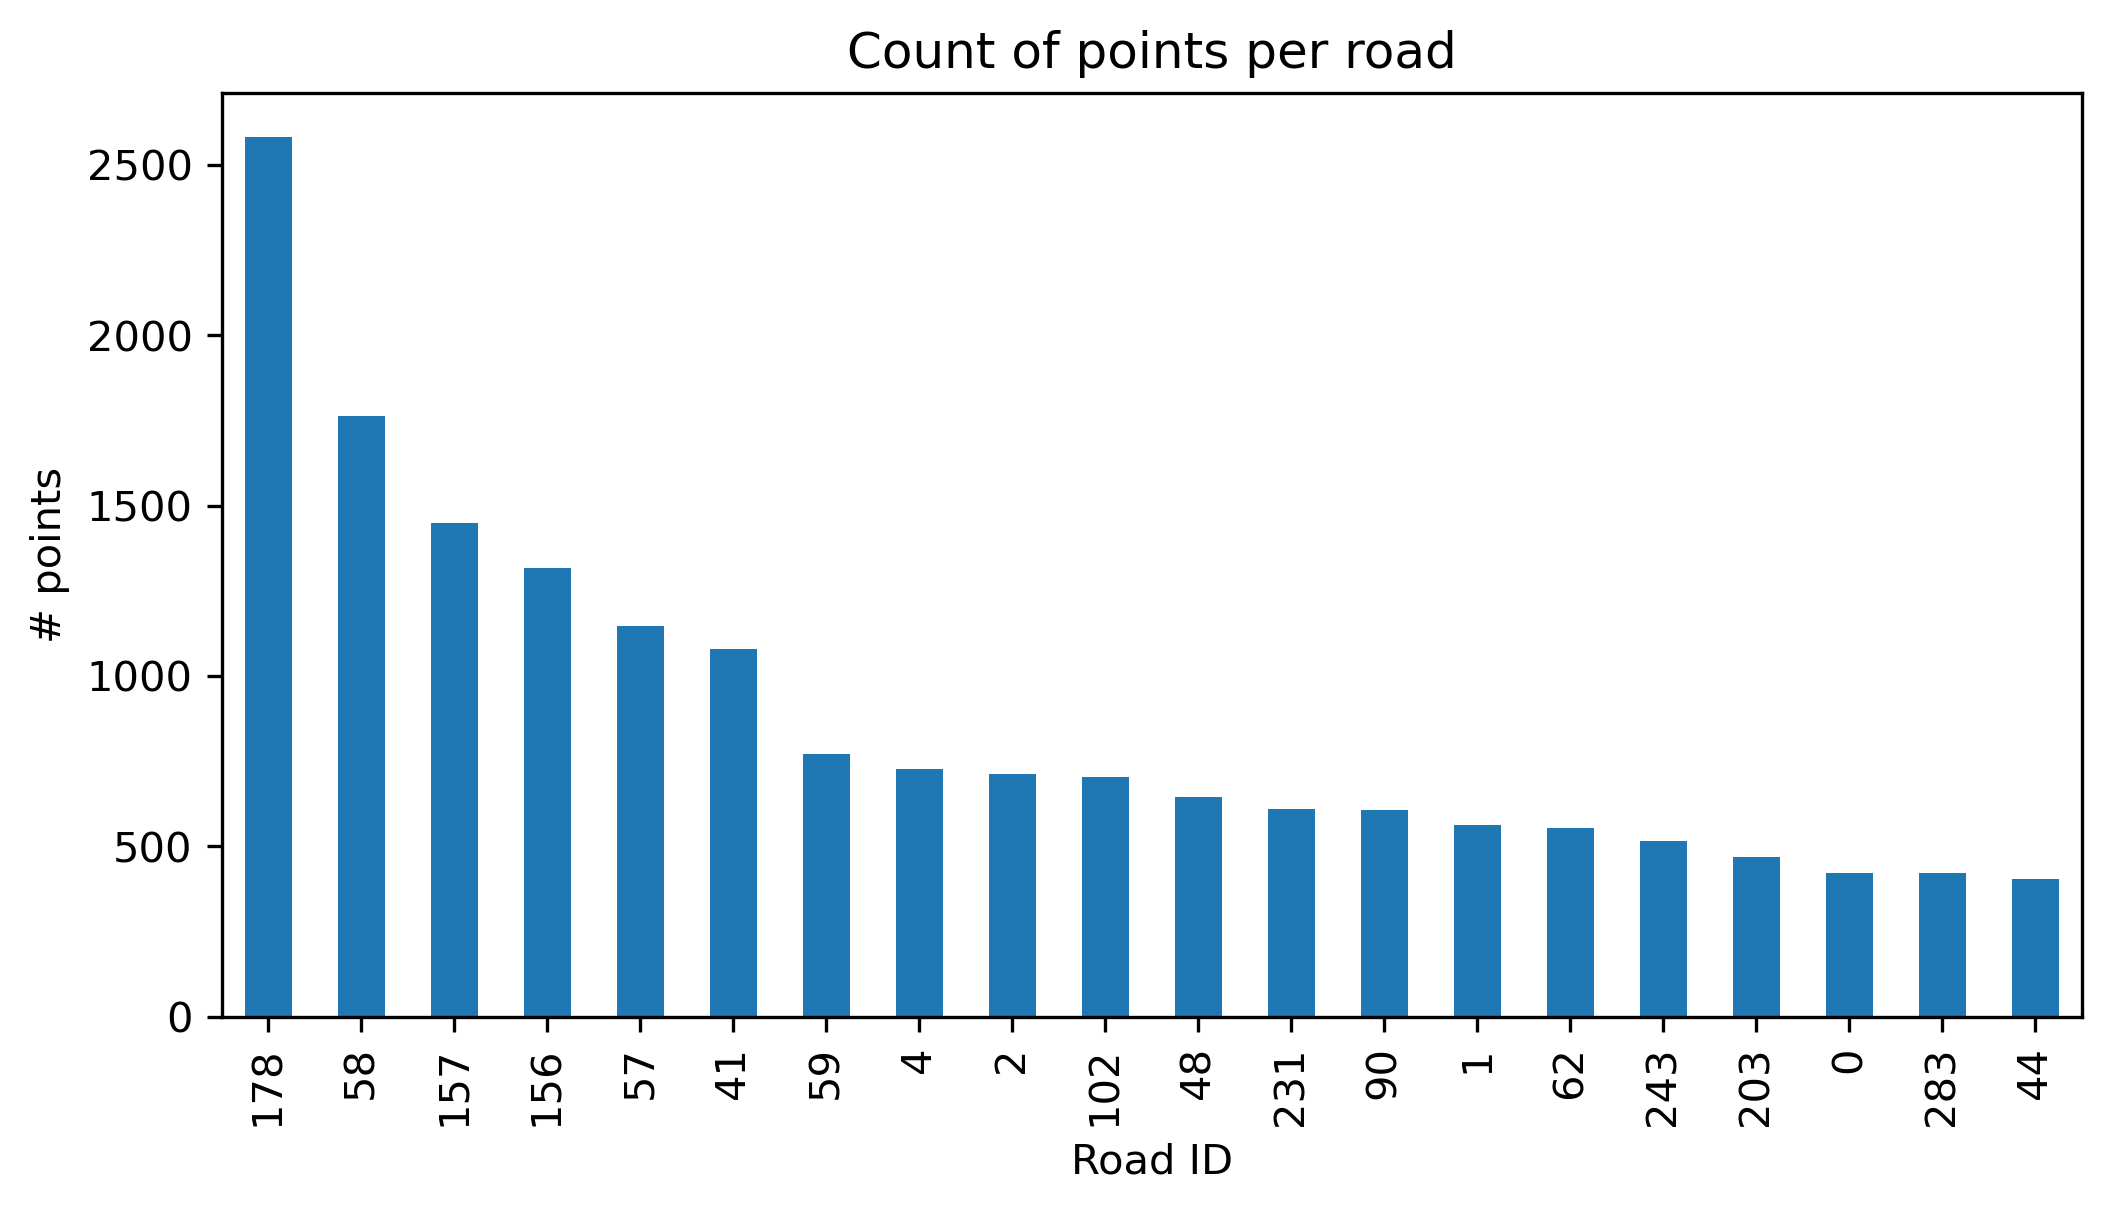

In [159]:
fig, ax = plt.subplots(figsize=[8, 4])
pts.road.value_counts().iloc[:20].plot(kind="bar", ax=ax)
plt.xlabel("Road ID")
plt.ylabel("# points")
plt.title("Count of points per road")


Separate point features matrix

In [160]:
pts_feats = pts.copy()
# compute time as fraction of day
# pts_feats["weekday"] = pts_feats.time.dt.weekday
# pts_feats["time_of_day"] =( pts_feats.time.dt.hour + pts_feats.time.dt.minute / 60) / 24
# time from hour to fraction of day
pts_feats["time"] = [t.hour + t.minute / 60 for t in pts_feats.time]
y = pts_feats[["pm25", "geometry"]]
pts_feats = pts_feats.drop(columns=["road", "tract", "lon", "lat", "pm25"])
# replace weekday with one-hot encoding
pts_feats = pd.get_dummies(pts_feats, columns=["weekday"], drop_first=True)

Point features

In [161]:
display(pts_feats)

time  temperature  humidity                    geometry  weekday_1  \
11       0.00        18.35     51.35  POINT (-73.86960 40.84740)      False   
16       0.00        18.50     51.10  POINT (-73.86900 40.84800)      False   
18       0.00        24.20     47.45  POINT (-73.89180 40.81920)       True   
19       0.00        24.20     47.60  POINT (-73.89150 40.81950)       True   
20       0.00        24.20     47.70  POINT (-73.89120 40.81980)       True   
...       ...          ...       ...                         ...        ...   
107070  23.75         6.50     74.10  POINT (-73.86960 40.84740)      False   
107073  23.75         6.50     73.65  POINT (-73.86900 40.84800)      False   
107078  23.75         6.70     71.70  POINT (-73.86780 40.84890)      False   
107085  23.75         7.00     65.80  POINT (-73.86660 40.84650)      False   
107087  23.75         7.20     64.80  POINT (-73.86630 40.84560)      False   

        weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
11          False      False      False      False      False  
16          False      False      False      False      False  
18          False      False      False      False      False  
19          False      False      False      False      False  
20          False      False      False      False      False  
...           ...        ...        ...        ...        ...  
107070      False      False      False      False       True  
107073      False      False      False      False       True  
107078      False      False      False      False       True  
107085      False      False      False      False       True  
107087      False      False      False      False       True  

[34482 rows x 10 columns]

Labels=y at the rank 0 level

In [162]:
display(y)

pm25                    geometry
11      4.566492  POINT (-73.86960 40.84740)
16      4.648553  POINT (-73.86900 40.84800)
18      7.608064  POINT (-73.89180 40.81920)
19      3.876476  POINT (-73.89150 40.81950)
20      3.891000  POINT (-73.89120 40.81980)
...          ...                         ...
107070  2.309777  POINT (-73.86960 40.84740)
107073  2.267851  POINT (-73.86900 40.84800)
107078  2.267851  POINT (-73.86780 40.84890)
107085  2.267851  POINT (-73.86660 40.84650)
107087  2.267851  POINT (-73.86630 40.84560)

[34482 rows x 2 columns]

### Road traffic level features

Columns: id, name, desc, county, route, fromMile, toMile, fc, latitude, longitude, AADT_2022, AAWDT_2022, PCT_2022, AADT_2021, AAWDT_2021, PCT_2021, AADT_2020, AAWDT_2020, PCT_2020, AADT_2019, AAWDT_2019, PCT_2019, AADT_2018, AAWDT_2018, PCT_2018, AADT_2017, AAWDT_2017, PCT_2017, AADT_2016, AAWDT_2016, PCT_2016, AADT_2015, AAWDT_2015, PCT_2015, AADT_2014, AAWDT_2014, PCT_2014, AADT_2013, AAWDT_2013, PCT_2013, geometry


id            name  \
0      010001000000          010001   
1      010002000000          010002   
2      010003000000            0191   
3      01000300000R  0199 (RETIRED)   
4      010004000000          010004   
...             ...             ...   
55815  978034000000          978034   
55816  978036000000          978036   
55817  978037000000          978037   
55818  978501000000          978501   
55819  978608000000          978608   

                                                    desc county  \
0      I-95 from NY/Bronx Co Line to I-87 MAJ DEEGAN ...  Bronx   
1      I-95 from I-87 MAJ DEEGAN EXP UNDER to MACOMBS...  Bronx   
2                              239 FT West of Jerome Ave   None   
3         I-95 from MACOMBS RD OVER to END I-95/US1 OLAP  Bronx   
4                             US1 from END I-95/US1 OLAP  Bronx   
...                                                  ...    ...   
55815       CR43 GOODRICH RD from NY 17C to GLEN MARY DR  Tioga   
55816  CR17 BERRY ROAD from HUNTS CREEK RD RD to STAN...  Tioga   
55817         N ELLISTOWN RD from BROAD ST EXT to NY 17C  Tioga   
55818  CR3 DEAN CREEK RD from EDGECOMB HILL RD to SPE...  Tioga   
55819  CR7 HALSEY VALLEY R from BARTON T/L to SPENCER...  Tioga   

                 route fromMile toMile                                     fc  \
0      ALEXANDER HAMIL        0   0.07  Urban:Principal Arterial - Interstate   
1      CROSS BRONX EXP     0.07   0.58  Urban:Principal Arterial - Interstate   
2                 None     None   None     LU:Principal Arterial - Interstate   
3      CROSS BRONX EXP     0.58   1.21  Urban:Principal Arterial - Interstate   
4          WEBSTER AVE     1.21   2.71       Urban:Principal Arterial - Other   
...                ...      ...    ...                                    ...   
55815      GOODRICH RD        0   0.53                            Urban:Local   
55816       BERRY ROAD        0   0.77                            Urban:Local   
55817   N ELLISTOWN RD        0   0.33                  Urban:Major Collector   
55818    DEAN CREEK RD     1.43   4.29                            Rural:Local   
55819  HALSEY VALLEY R     8.48   9.37                  Rural:Major Collector   

        latitude   longitude  ... AADT_2015 AAWDT_2015 PCT_2015 AADT_2014  \
0      40.844940  -73.926880  ...      None       None     None      None   
1      40.844880  -73.920390  ...    99,399       None     9.1%   102,658   
2      40.845008  -73.915372  ...   153,360       None    14.8%   162,758   
3      40.844841  -73.906159  ...   153,360       None    14.8%   162,758   
4      40.853662  -73.897180  ...    17,188     18,288     6.1%      None   
...          ...         ...  ...       ...        ...      ...       ...   
55815  42.101200  -76.287090  ...     1,681       None     5.6%     1,700   
55816  42.059350  -76.317980  ...       573       None    11.0%       579   
55817  42.006300  -76.507490  ...     1,720       None     7.5%     1,738   
55818  42.136158  -76.526014  ...      None       None     None      None   
55819  42.148480  -76.444410  ...       766       None     7.7%       682   

      AAWDT_2014 PCT_2014 AADT_2013 AAWDT_2013 PCT_2013  \
0           None     None      None       None     None   
1           None     9.3%   106,024       None     9.2%   
2           None    14.8%   154,510       None    14.8%   
3        143,311    14.8%      None       None     None   
4           None     None      None       None     None   
...          ...      ...       ...        ...      ...   
55815       None     5.6%     1,718      2,040     5.5%   
55816       None    10.9%       586       None    10.9%   
55817      1,749     7.4%     1,867       None     5.9%   
55818       None     None      None       None     None   
55819       None     7.6%       597        617     7.7%   

                         geometry  
0      POINT (-73.92688 40.84494)  
1      POINT (-73.92039 40.84488)  
2      POINT (-73.91537 40.8

Text(0.5, 1.0, 'AADT 2020 in Bronx, NY')

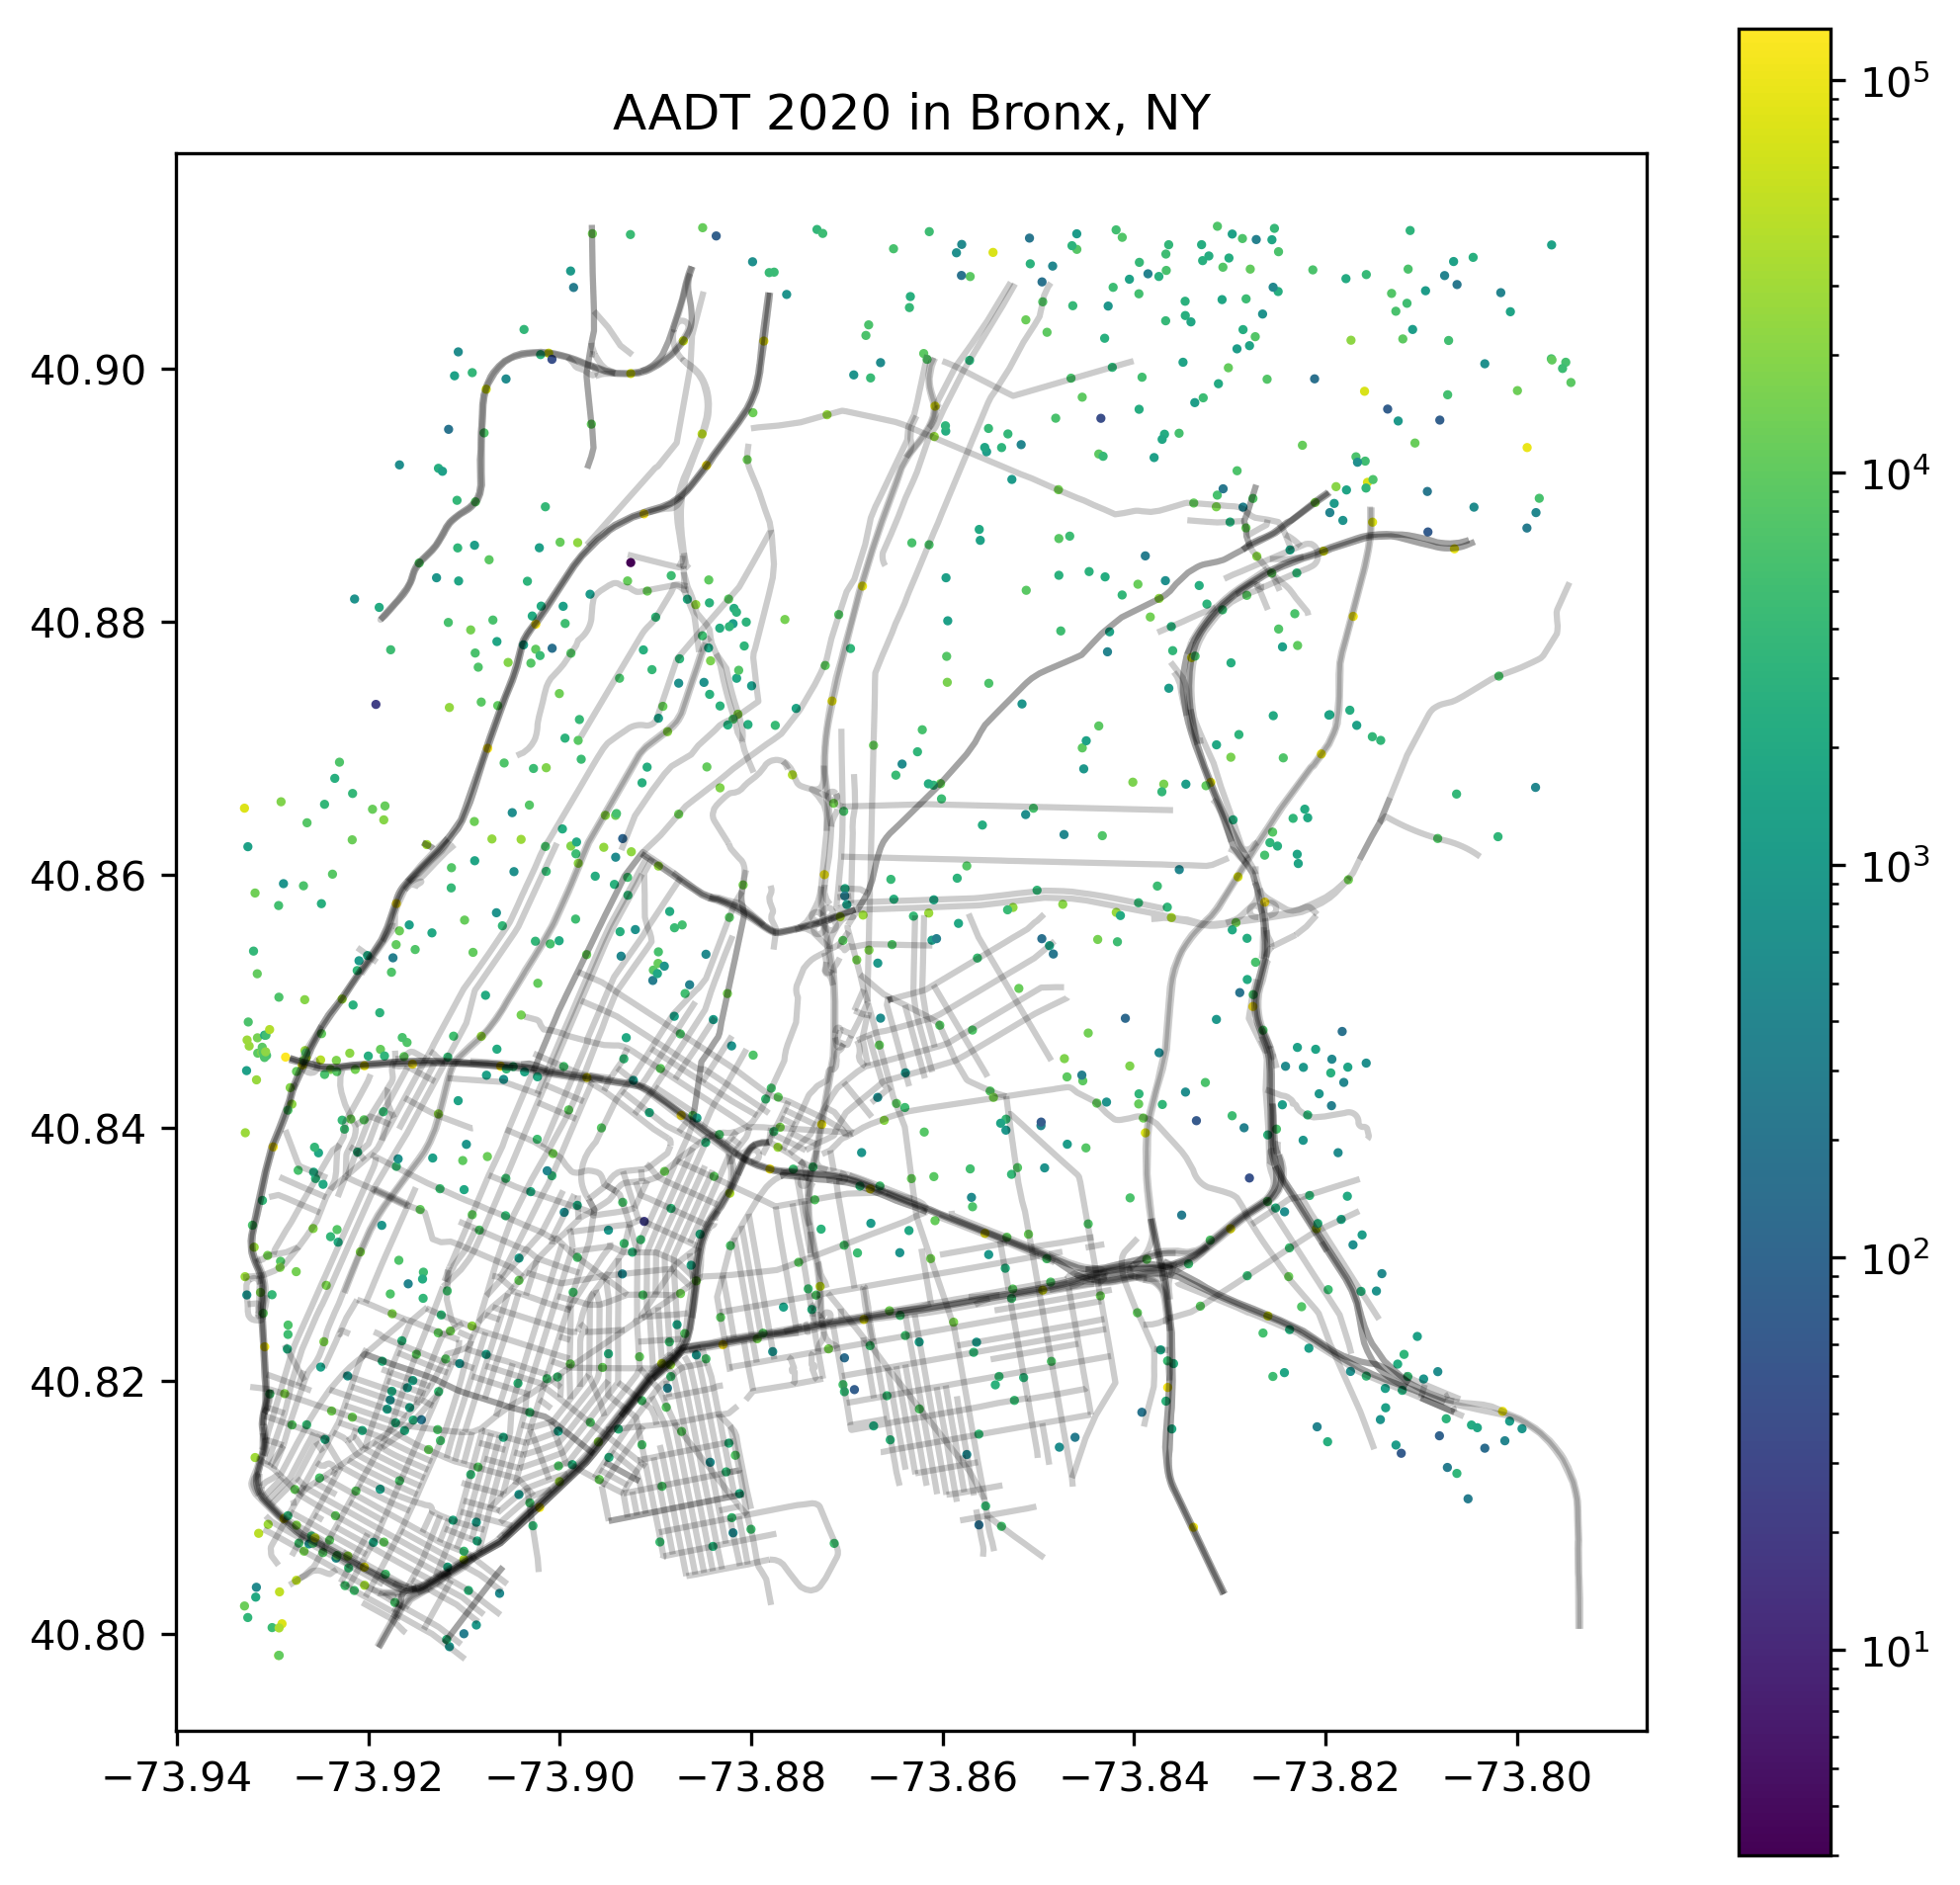

In [163]:
import matplotlib

# load aadt data, crs=2263, used in NYC commonly, convert to WGS84
aadt = gpd.read_file(
    "data/raw/aadt_and_truckpct/features.shp", crs="EPSG:2263"
).to_crs(wgs84)
print("Columns:", ", ".join(aadt.columns))
display(aadt)

# coerce the following vars to numeric, handling comma-separated numbers and % signs
c = ["AADT_2020", "AAWDT_2020", "PCT_2020"]
for col in c:
    aadt[col] = pd.to_numeric(aadt[col].str.replace(",", "").str.replace("%", ""))


# crop to bounds of Bronx
aadt = aadt.cx[
    roads.total_bounds[0] : roads.total_bounds[2],
    roads.total_bounds[1] : roads.total_bounds[3],
]

# plot the points overlay the roads, use log scale
ax = roads.plot(color="black", alpha=0.2)
norm = matplotlib.colors.LogNorm(vmin=aadt.AADT_2020.min(), vmax=aadt.AADT_2020.max())
aadt.plot("AADT_2020", markersize=1.5, ax=ax, legend=True, norm=norm)
plt.title("AADT 2020 in Bronx, NY")

  0%|          | 0/692 [00:00<?, ?it/s]

AADT_2020   PCT_2020  \
1762   6760.874019   5.700416   
919   15256.426888  11.315406   
538   21707.884494  10.392795   
3012  14691.489566   9.570367   
3013  20797.361018   8.917330   
...            ...        ...   
1038  35761.326732   7.872293   
1899   4148.328159   7.214608   
3074   1450.574992   5.934299   
916   74511.763766  11.616856   
1617  74208.793510  11.610846   

                                               geometry  
1762  LINESTRING (-73.86782 40.84990, -73.86837 40.8...  
919   LINESTRING (-73.90635 40.80750, -73.90596 40.8...  
538   LINESTRING (-73.90635 40.80750, -73.90609 40.8...  
3012  LINESTRING (-73.91905 40.79899, -73.91893 40.7...  
3013  LINESTRING (-73.91739 40.80125, -73.91713 40.8...  
...                                                 ...  
1038  LINESTRING (-73.83006 40.86205, -73.82965 40.8...  
1899  LINESTRING (-73.82492 40.83890, -73.82498 40.8...  
3074  LINESTRING (-73.82624 40.84299, -73.82581 40.8...  
916   LINESTRING (-73.82734 40.85940, -73.82737 40.8...  
1617  LINESTRING (-73.82734 40.85940, -73.82740 40.8...  

[692 rows x 3 columns]

Text(0.5, 1.0, 'Road AADT 2020 in Bronx, NY')

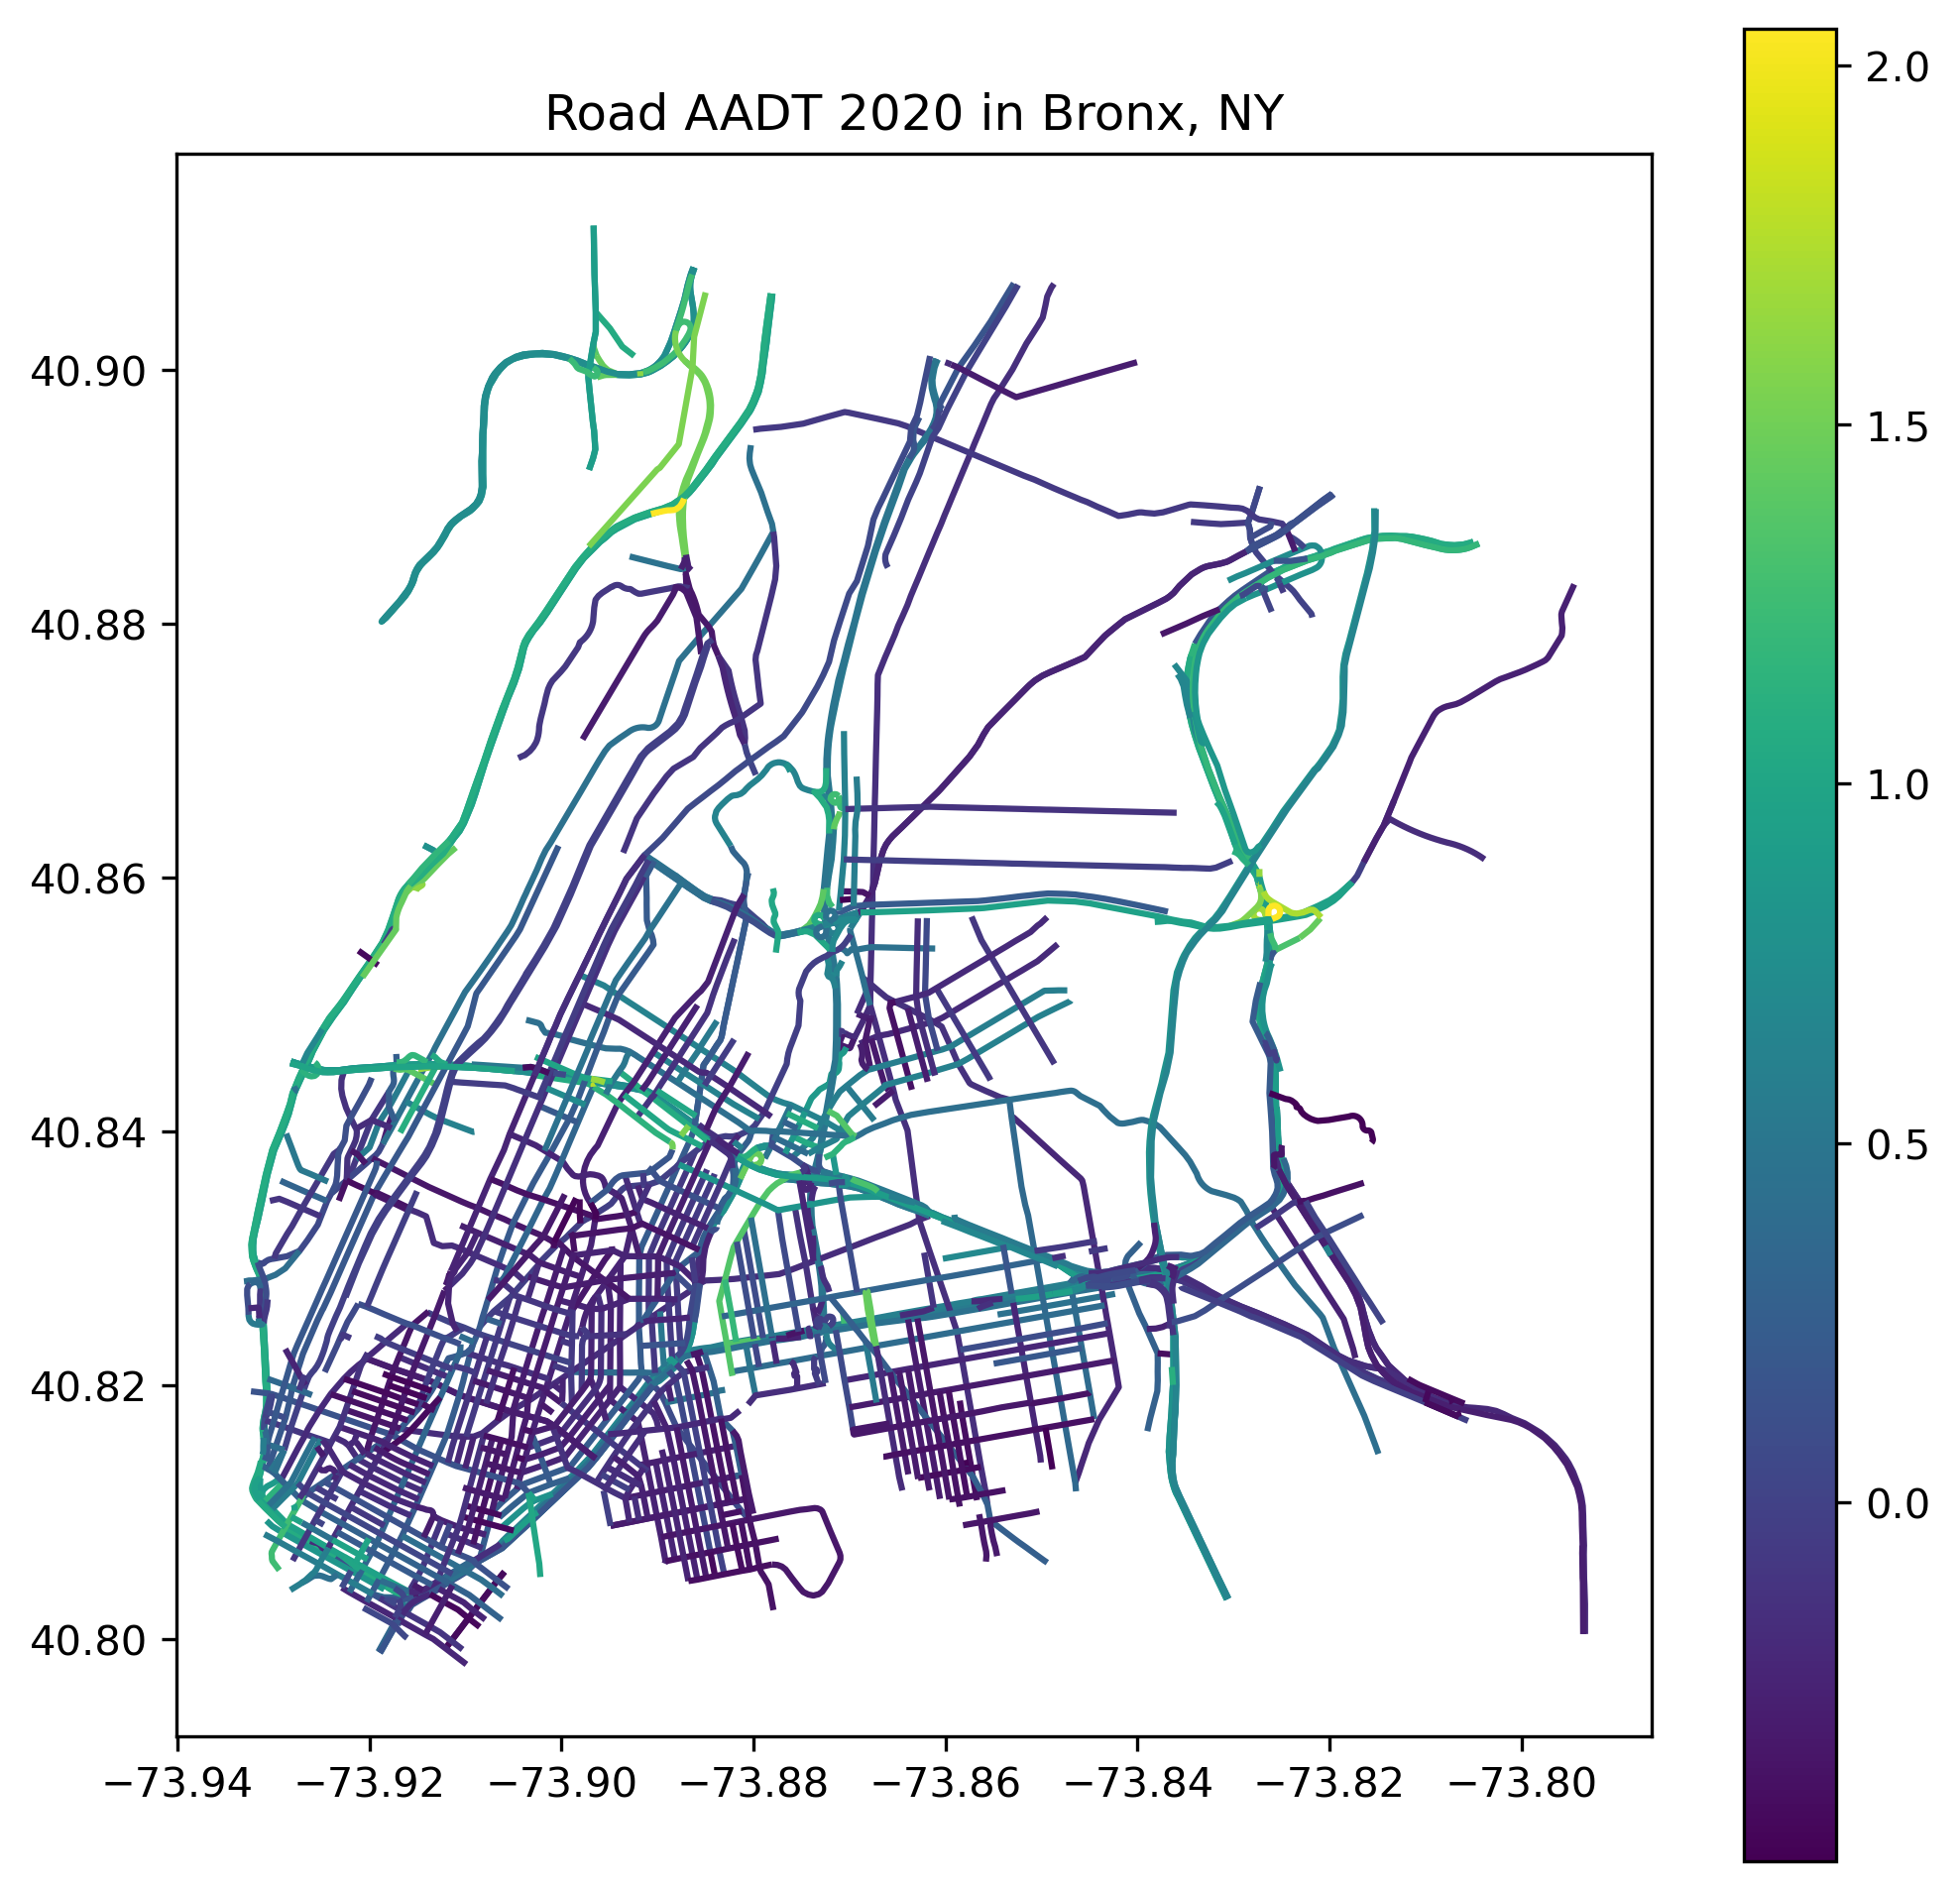

In [164]:
# make a weighted knn predictor
from sklearn.neighbors import KNeighborsRegressor

c = ["AADT_2020", "PCT_2020"]
Y = aadt[c]  # pandas
X = aadt[["longitude", "latitude"]]
knn = KNeighborsRegressor(n_neighbors=3, weights="distance")

# # remove NaNs
nan_ix = Y.isna().any(axis=1)
X = X.loc[~nan_ix]
Y = Y.loc[~nan_ix]

knn.fit(X, Y)

# predict AADT for each road, evaluate on all the points of the line and average
road_feats = []
for ix, row in tqdm(roads.iterrows(), total=roads.shape[0]):
    road = row.geometry
    lon, lat = road.xy
    Xtest = pd.DataFrame({"longitude": lon, "latitude": lat})
    preds = knn.predict(Xtest)
    road_feats.append(preds.mean(axis=0))
road_feats = np.array(road_feats)
road_feats = gpd.GeoDataFrame(
    road_feats, columns=Y.columns, geometry=roads.geometry.values, index=roads.index
)
display(road_feats)

# apply the scaled symlog transform
def scaled_symlog(x):
    m = x.median()
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    x_scaled = (x - m) / iqr
    return np.sign(x_scaled) * np.log1p(np.abs(x_scaled))


# norm = matplotlib.colors.LogNorm(vmin=roads.AADT_2019.min(), vmax=roads.AADT_2019.max())
road_feats_ = road_feats.copy()
road_feats_["AADT_2020"] = scaled_symlog(road_feats["AADT_2020"])
road_feats_.plot("AADT_2020", legend=True)
plt.title("Road AADT 2020 in Bronx, NY")

### Features by census tracts from NYC zoning

Columns: borough, tax_block, lot, cd, tract, block, ct2010, cb2010, schooldist, council, zipcode, firecomp, policeprct, healthcenterdistrict, healtharea, sanitboro, sanitdistrict, sanitsub, address, zonedist1, zonedist2, zonedist3, zonedist4, overlay1, overlay2, spdist1, spdist2, spdist3, ltdheight, splitzone, bldgclass, landuse, easements, ownertype, ownername, lotarea, bldgarea, comarea, resarea, officearea, retailarea, garagearea, strgearea, factryarea, otherarea, areasource, numbldgs, numfloors, unitsres, unitstotal, lotfront, lotdepth, bldgfront, bldgdepth, ext, proxcode, irrlotcode, lottype, bsmtcode, assessland, assesstot, exempttot, yearbuilt, yearalter1, yearalter2, histdist, landmark, builtfar, residfar, commfar, facilfar, borocode, bbl, condono, tract2010, xcoord, ycoord, zonemap, zmcode, sanborn, taxmap, edesignum, appbbl, appdate, plutomapid, firm07_flag, pfirm15_flag, version, dcpedited, latitude, longitude, notes


borough  tax_block  lot     cd  tract  block  ct2010  cb2010  \
8           BX       3032  129  206.0  38304   1001  383.02  1001.0   
9           BX       2956    2  206.0  36502   2000  365.02  2000.0   
11          BX       5413   81  210.0  27401   2001  274.01  2001.0   
12          BX       5413    9  210.0  27401   1000  274.01  1000.0   
13          BX       5413  128  210.0  27401   2000  274.01  2000.0   
...        ...        ...  ...    ...    ...    ...     ...     ...   
858391      BX       3832   10  209.0   9600   1000   96.00  1000.0   
858417      BX       2391   45  203.0  14300   1007  143.00  1016.0   
858418      BX       5744   48  208.0  29301   2000  293.01  2000.0   
858537      BX       5406   67  210.0  27401   3010  274.01  3009.0   
858543      BX       5745  105  208.0  29301   1000  293.01  1000.0   

        schooldist  council  ...        appbbl     appdate  plutomapid  \
8             10.0     15.0  ...           NaN         NaN           1   
9             12.0     15.0  ...           NaN         NaN           1   
11             8.0     13.0  ...           NaN         NaN           1   
12             8.0     13.0  ...           NaN         NaN           1   
13             8.0     13.0  ...           NaN         NaN           1   
...            ...      ...  ...           ...         ...         ...   
858391         8.0     18.0  ...           NaN         NaN           1   
858417         9.0     16.0  ...  2.023910e+09  11/16/2009           1   
858418        10.0     11.0  ...           NaN         NaN           1   
858537         8.0     13.0  ...           NaN         NaN           1   
858543        10.0     11.0  ...           NaN         NaN           1   

        firm07_flag  pfirm15_flag  version  dcpedited   latitude  longitude  \
8               NaN           NaN   24v1.1        NaN  40.860247 -73.892348   
9               NaN           NaN   24v1.1        NaN  40.843836 -73.889176   
11              NaN           NaN   24v1.1        NaN  40.846491 -73.821691   
12              NaN           NaN   24v1.1        NaN  40.847164 -73.822513   
13              NaN           NaN   24v1.1        NaN  40.847480 -73.820459   
...             ...           ...      ...        ...        ...        ...   
858391          NaN           NaN   24v1.1        NaN  40.834433 -73.848158   
858417          NaN           NaN   24v1.1        NaN  40.827105 -73.912030   
858418          NaN           NaN   24v1.1        NaN  40.881780 -73.920658   
858537          NaN           NaN   24v1.1        NaN  40.839107 -73.823196   
858543          1.0           1.0   24v1.1        NaN  40.884256 -73.921104   

       notes  
8        NaN  
9        NaN  
11       NaN  
12       NaN  
13       NaN  
...      ...  
858391   NaN  
858417   NaN  
858418   NaN  
858537   NaN  
858543   NaN  

[89061 rows x 92 columns]

  0%|          | 0/89061 [00:00<?, ?it/s]

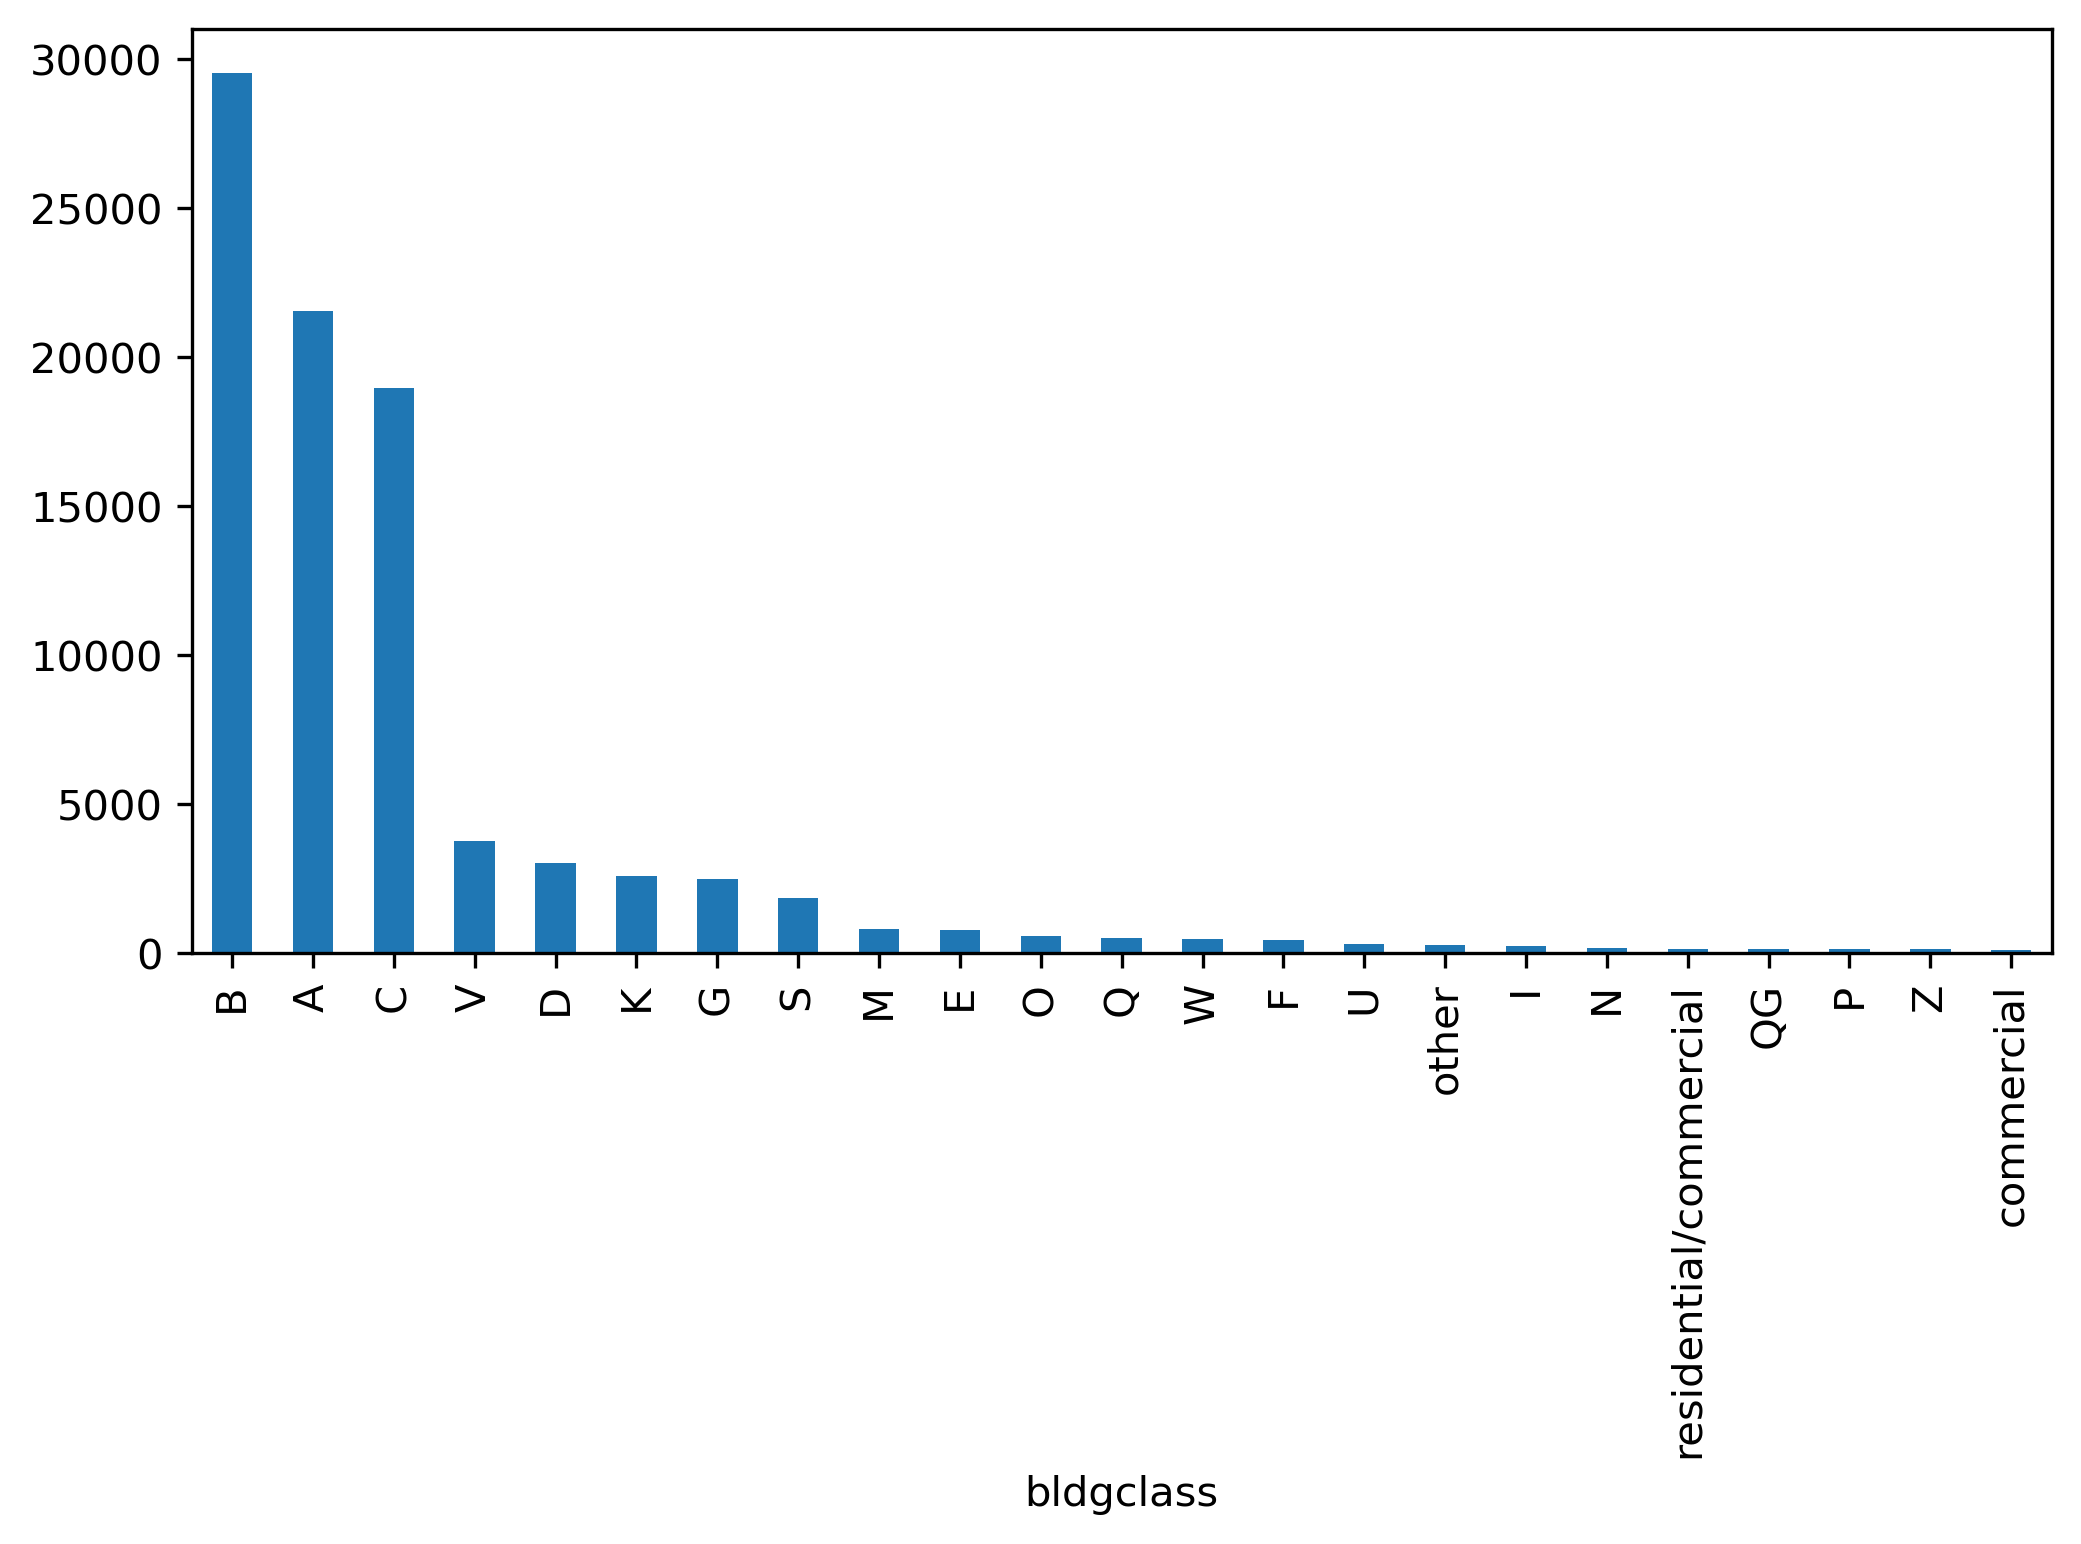

/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_33758/3966173528.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'one_two_family' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.landuse.isin(classes), "landuse"] = new_class


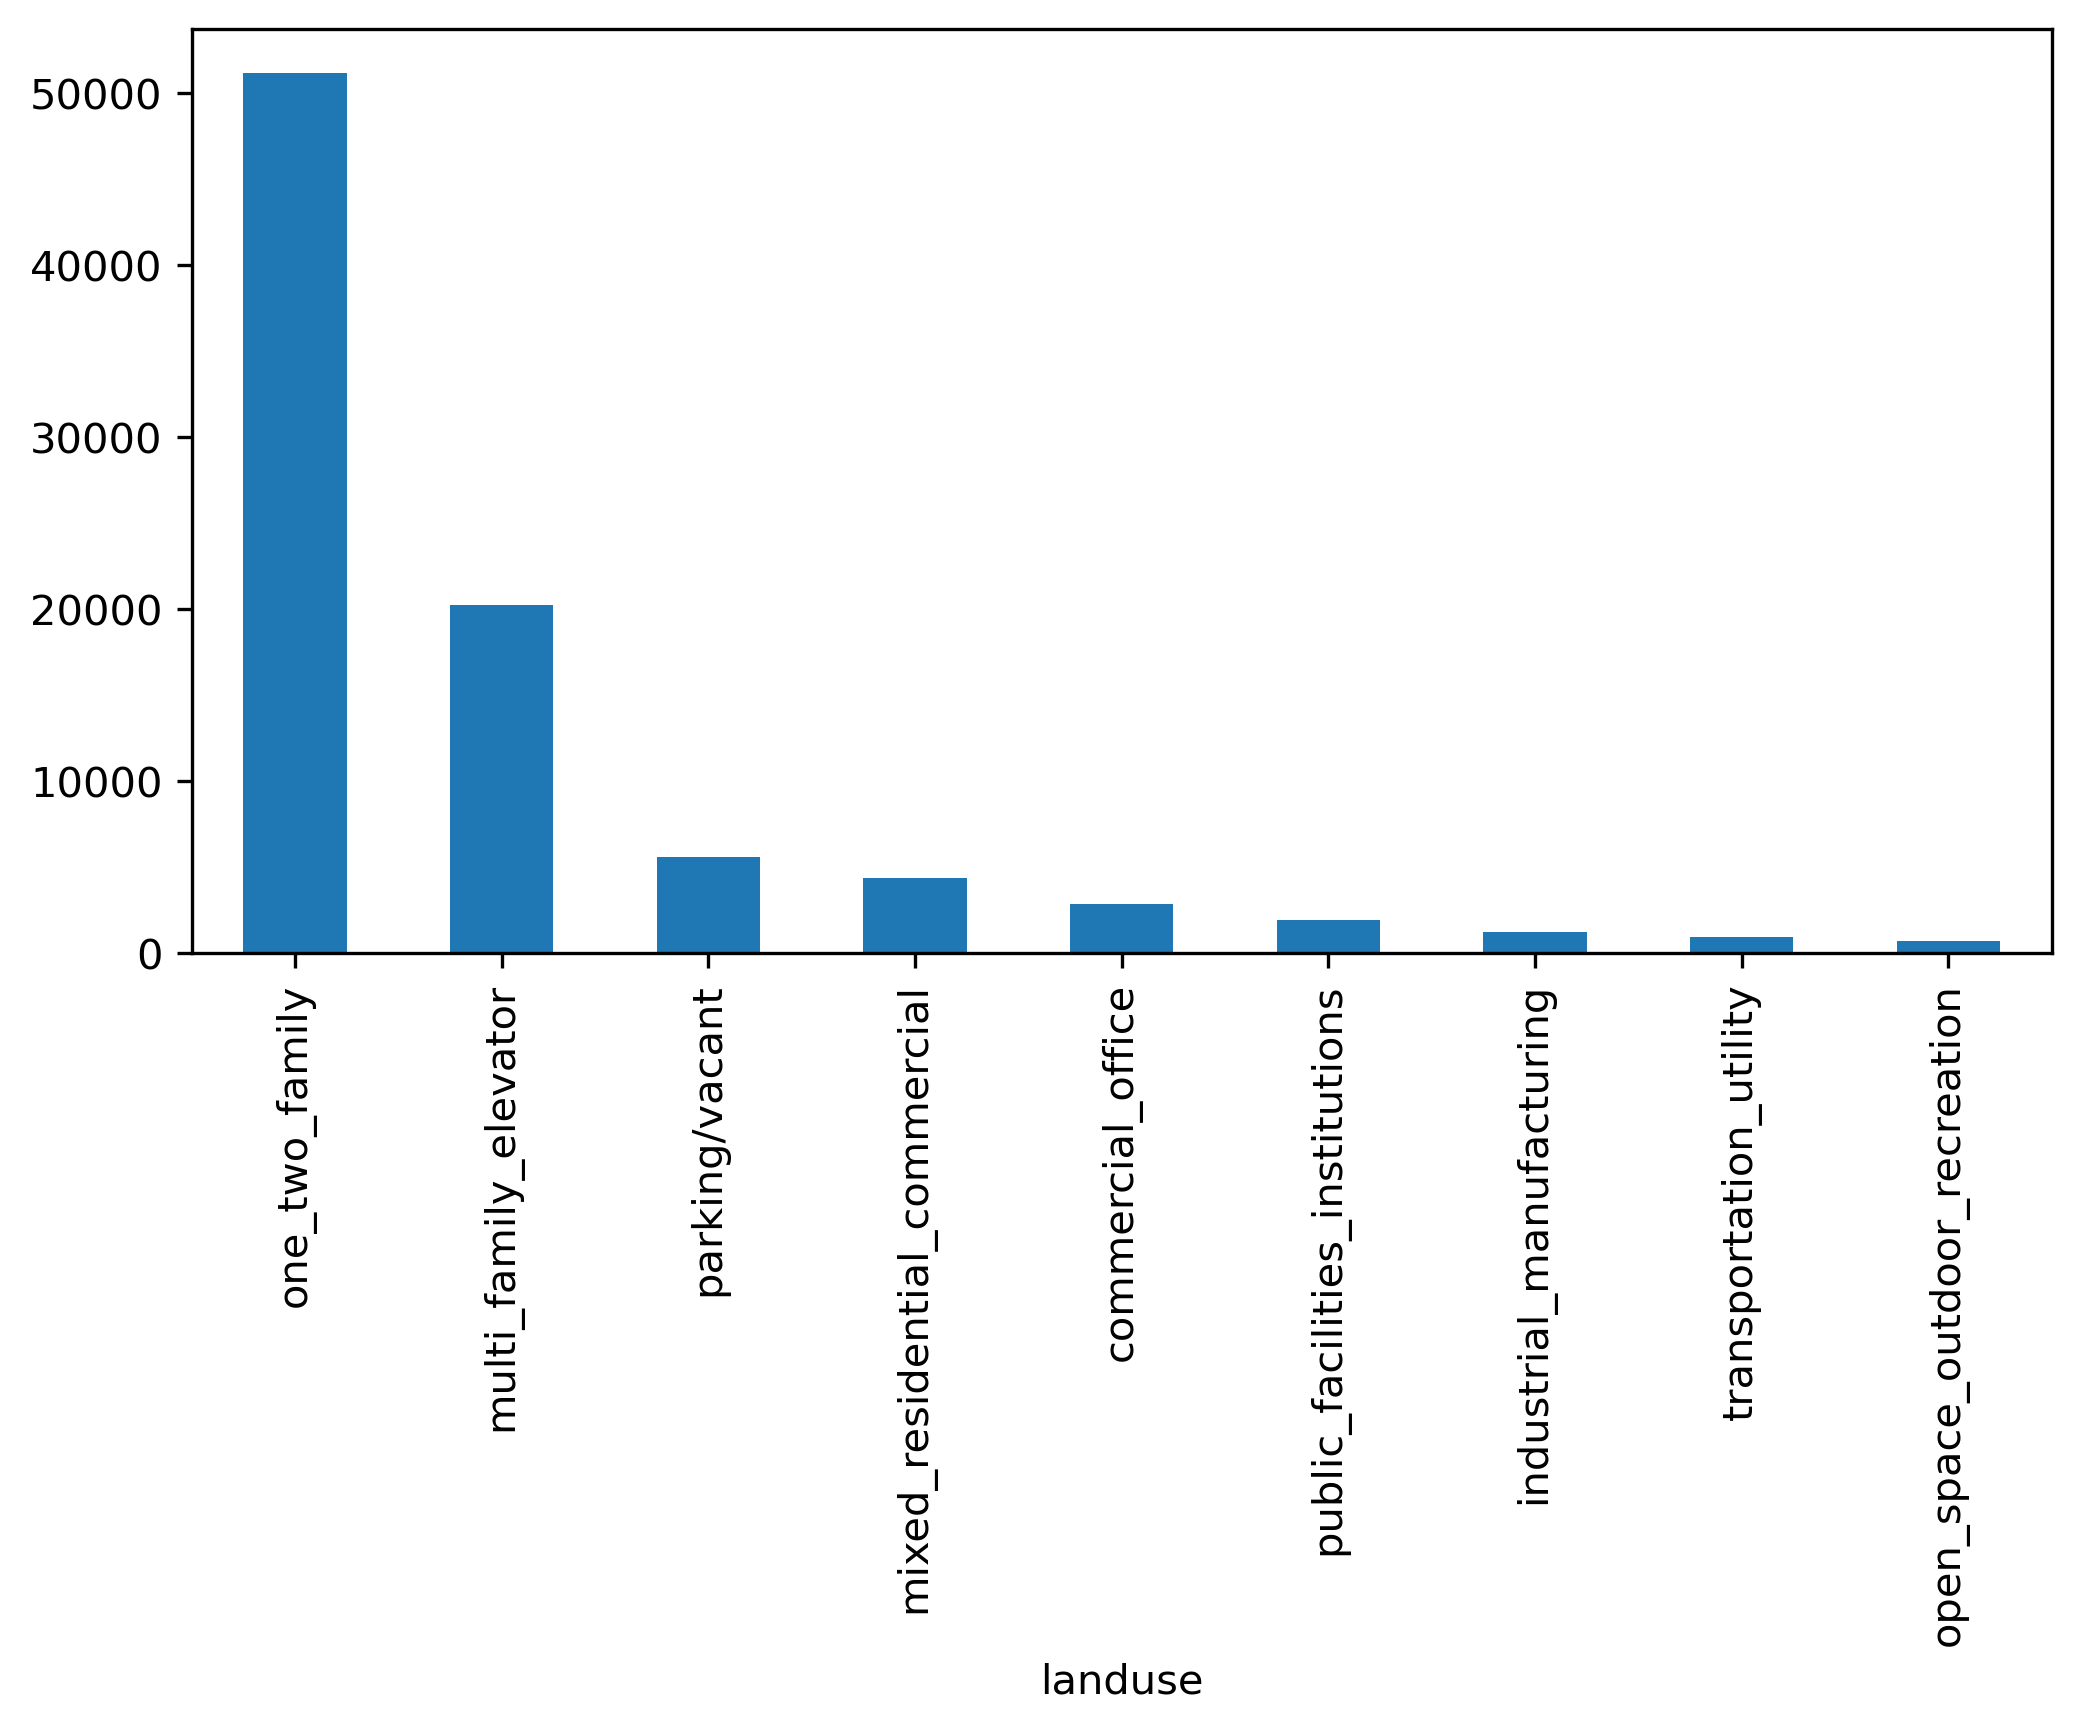

New dummy columns: bldgclass_B, bldgclass_C, bldgclass_D, bldgclass_E, bldgclass_F, bldgclass_G, bldgclass_I, bldgclass_K, bldgclass_M, bldgclass_N, bldgclass_O, bldgclass_P, bldgclass_Q, bldgclass_QG, bldgclass_S, bldgclass_U, bldgclass_V, bldgclass_W, bldgclass_Z, bldgclass_commercial, bldgclass_other, bldgclass_residential/commercial, landuse_industrial_manufacturing, landuse_mixed_residential_commercial, landuse_multi_family_elevator, landuse_one_two_family, landuse_open_space_outdoor_recreation, landuse_parking/vacant, landuse_public_facilities_institutions, landuse_transportation_utility
Columns: bldgarea, comarea, resarea, officearea, retailarea, factryarea, bldgclass_B, bldgclass_C, bldgclass_D, bldgclass_E, bldgclass_F, bldgclass_G, bldgclass_I, bldgclass_K, bldgclass_M, bldgclass_N, bldgclass_O, bldgclass_P, bldgclass_Q, bldgclass_QG, bldgclass_S, bldgclass_U, bldgclass_V, bldgclass_W, bldgclass_Z, bldgclass_commercial, bldgclass_other, bldgclass_residential/commercial, landu

id  bldgarea   comarea   resarea  officearea  retailarea  factryarea  \
0      200  0.266297  0.014688  0.230103    0.000223    0.004151    0.002596   
1      400  0.264036  0.014356  0.235935    0.000527    0.003073    0.000000   
2     1600  1.069532  0.438426  0.601089    0.081915    0.018124    0.000000   
3     1901  3.812645  0.911818  2.854734    0.216406    0.230910    0.056124   
4     1902  1.425532  0.997668  0.346947    0.081079    0.031895    0.537697   
..     ...       ...       ...       ...         ...         ...         ...   
183  46207  1.902246  1.902246  0.000000    0.000000    0.848956    0.000000   
184  46208  0.749733  0.234175  0.472438    0.006867    0.017525    0.022294   
185  46209  0.655938  0.287899  0.348172    0.018474    0.050552    0.048227   
186  48401  0.620076  0.222253  0.355940    0.007100    0.023833    0.076555   
187  50400  0.002895  0.002895  0.000000    0.000679    0.000016    0.000000   

     bldgclass_B  bldgclass_C  bldgclass_D  ...  landuse_parking/vacant  \
0       0.000158     0.000048     0.000000  ...                0.000664   
1       0.000168     0.000035     0.000000  ...                0.000255   
2       0.000282     0.000186     0.000360  ...                0.000398   
3       0.000000     0.000762     0.004234  ...                0.001818   
4       0.000122     0.000138     0.000110  ...                0.000204   
..           ...          ...          ...  ...                     ...   
183     0.000000     0.000000     0.000000  ...                0.000000   
184     0.000390     0.000161     0.000000  ...                0.000085   
185     0.000181     0.000156     0.000863  ...                0.000468   
186     0.000314     0.000160     0.000000  ...                0.000158   
187     0.000000     0.000000     0.000000  ...                0.000596   

     landuse_public_facilities_institutions  landuse_transportation_utility  \
0                                  0.000015                        0.000000   
1                                  0.000015                        0.000002   
2                                  0.000718                        0.000000   
3                                  0.000550                        0.000204   
4                                  0.000065                        0.000541   
..                                      ...                             ...   
183                                0.000000                        0.000000   
184                                0.000135                        0.000082   
185                                0.000105                        0.000709   
186                                0.000091                        0.000157   
187                                0.000000                        0.000964   

      lotarea  assesstot    lotfront    lotdepth   bldgfront   bldgdepth  \
0    0.583213   0.000214    0.339109    0.434072    0.010054    0.018615   
1    0.849728   0.008111    0.410327    0.761597    0.036500    0.028083   
2    0.333306   0.032768    0.888606    0.890461    0.279794    0.294793   
3    0.069696   0.181801    2.123340    2.481584    1.475738    1.472475   
4    0.226121   0.004670    0.469884    0.557185    0.279010    0.335857   
..        ...        ...         ...         ...         ...         ...   
183  0.026264  27.613800  278.330000  676.000000  438.000000  292.000000   
184  0.277534   0.002281    0.141136    0.174394    0.063518    0.074325   
185  0.316518   0.011394    0.886363    1.003565    0.366606    0.289836   
186  0.325851   0.001353    0.125650    0.199098    0.068545    0.075266   
187  9.055977   7.258759   60.549527  267.164490    1.408605    0.497155   

                                              geometry  
0    POLYGON ((-73.86648 40.80590, -73.86222 40.810...  
1    POLYGON ((-73.85870 40.81540, -73.85778 40.815...  
2    POLYGON ((-73.86246 40.81925, -73.86153 40.819...  
3    POLYGON ((-73.93094 40.80825, -73.92933 40.809...  

Text(0.5, 1.0, 'Retailarea in Bronx, NY')

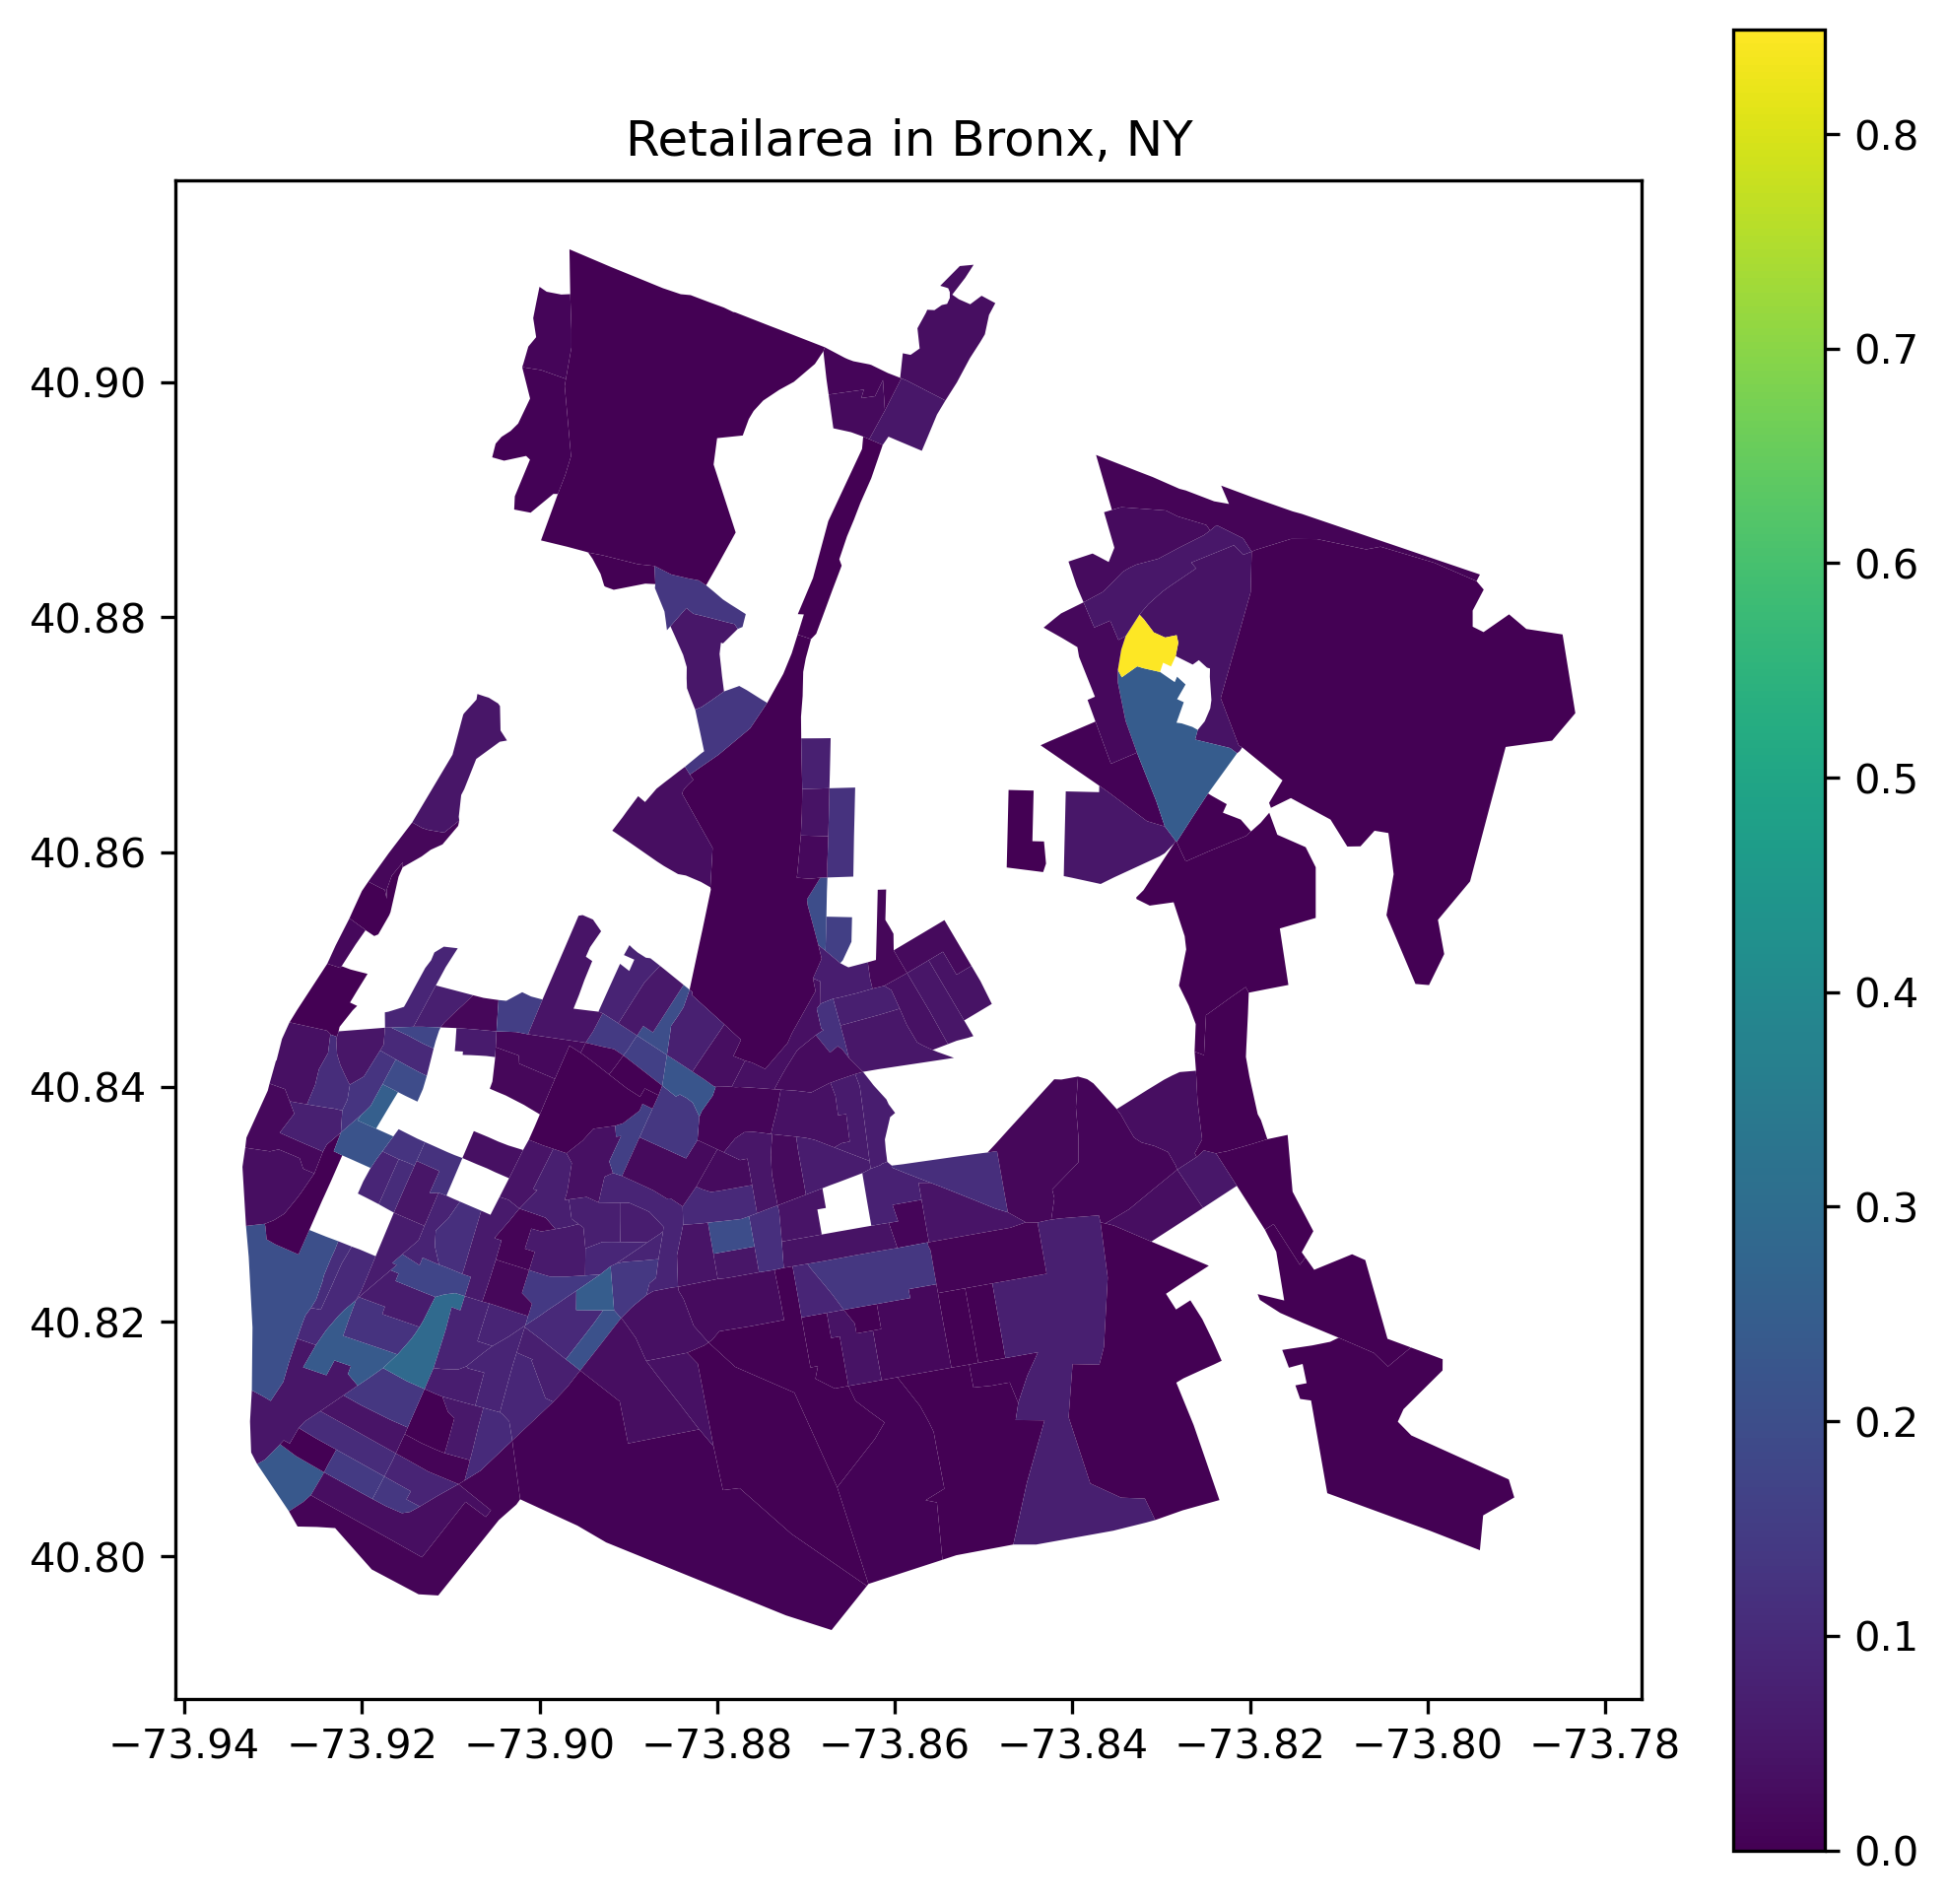

In [165]:
import re

# Primary Land Use Tax Lot Output (PLUTO)
# crs=2263, used in NYC commonly, convert to WGS84
df = pd.read_csv("data/raw/nyc_pluto_24v1_1_csv/pluto_24v1_1.csv", low_memory=False)
df.rename(columns={"block": "tax_block"}, inplace=True)
df.rename(columns={"bctcb2020": "block"}, inplace=True)
df.rename(columns={"bct2020": "tract"}, inplace=True)
print("Columns:", ", ".join(df.columns))

# remove NaNs from bctcb2020zw
df = df[df.borough == "BX"]

# process as string and keep only last 4 digits
df = df[df.block.notna() & df.landuse.notna() & df.bldgclass.notna()]
df["block"] = df["block"].astype(int).astype(str).str[-4:].astype(int)
df["tract"] = df["tract"].astype(int).astype(str).str[-6:].astype(int)
display(df)

# transform assesstot to millions of dollar
df["assesstot"] = df["assesstot"] / 1e6

# categorical variables to be made one-hot and summed
cat_cols = ["bldgclass", "landuse"]


# preprocess building class
# see pluto data dictionary
mapping = [
    (["R5", "R7", "R8", "RA", "RB", "RH", "RK", "RD"], "residential"),
    (["R1", "R2", "R3", "R4", "R6", "RR", "RC"], "commercial"),
    (["R9", "RM"], "residential/commercial"),
    (["RI", "RW"], "industrial/warehouse"),
    (["RZ"], "residential/industrial"),
    (["RG", "RP", "RS", "RT"], "parking/storage/terraces"),
]

# map classes
for classes, new_class in mapping:
    df.loc[df.bldgclass.isin(classes), "bldgclass"] = new_class

# for the rest, remove the number, just keep the lettter
new_vals = []
for ix, row in tqdm(df.iterrows(), total=df.shape[0]):
    val = row.bldgclass
    if val not in [x[1] for x in mapping]:
        val = re.sub(r"[0-9]", "", val)
    new_vals.append(val)
df["bldgclass"] = new_vals

# make all classes that appear less than 100 times as "other"
cnts = df.bldgclass.value_counts()
df.loc[df.bldgclass.isin(cnts[cnts < 100].index), "bldgclass"] = "other"

# display counts
# display(df.bldgclass.value_counts())
plt.figure(figsize=(8, 4))
df.bldgclass.value_counts().plot(kind="bar")
plt.show()

area_feats = [
    "bldgarea",
    "comarea",
    "resarea",
    "officearea",
    "retailarea",
    "factryarea",
]

# map land use
mapping = [
    ([1], "one_two_family"),
    ([2, 3], "multi_family_elevator"),
    ([4], "mixed_residential_commercial"),
    ([5], "commercial_office"),
    ([6], "industrial_manufacturing"),
    ([7], "transportation_utility"),
    ([8], "public_facilities_institutions"),
    ([9], "open_space_outdoor_recreation"),
    ([10, 11], "parking/vacant"),
]
df["landuse"] = df["landuse"].astype(int)
for classes, new_class in mapping:
    df.loc[df.landuse.isin(classes), "landuse"] = new_class


# display counts
plt.figure(figsize=(8, 4))
df.landuse.value_counts().plot(kind="bar")
plt.show()

# features to be averaged by LotArea
av_feats = ["assesstot", "lotfront", "lotdepth", "bldgfront", "bldgdepth"]

orig_cols = df.columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, prefix=cat_cols)
new_cat_cols = list(df.columns.difference(orig_cols))
print("New dummy columns:", ", ".join(new_cat_cols))

# do groupby, start with sum
dfagg = df.groupby(["tract"])[
    area_feats + new_cat_cols + ["lotarea"]
].sum()


# now compute an weighted average of av_feats by LotArea
def nan_weighted_mean(x, wts):
    isna = np.isnan(x) | np.isnan(wts)
    x = x[~isna]
    wts = wts[~isna] + 1e-6
    return np.nanmean(x * wts) / np.nansum(wts)


for col in av_feats + new_cat_cols:
    dfagg[col] = df.groupby("tract")[[col, "lotarea"]].apply(
        lambda x: nan_weighted_mean(x[col].values, x.lotarea.values)
    )


# transform the count and area features to density and pcts respectively by dividing by lotarea
for col in area_feats:
    dfagg[col] = dfagg[col] / dfagg["lotarea"]

# transform lot area from squared feed to squared kilometers
dfagg["lotarea"] = dfagg["lotarea"] * 0.000000092903

# remove nans
dfagg = dfagg.dropna()
print("Columns:", ", ".join(dfagg.columns))

# find the elements in dfagg.index that are also in tracts.TRACTCE
indexes = dfagg.index[dfagg.index.isin(tracts.index)]
dfagg = dfagg.loc[indexes]
tracts = tracts.loc[indexes]

# convert to gpd
tract_feats = gpd.GeoDataFrame(
    dfagg, geometry=tracts.geometry.loc[dfagg.index], crs=tracts.crs, index=dfagg.index
)
tract_feats = tract_feats.reset_index()
tract_feats = tract_feats.rename({"tract": "id"}, axis=1)
display(tract_feats)

# plot features as an example
# bldgdepth
tract_feats_ = tract_feats.copy()
# tract_feats_["retailarea"] = scaled_symlog(tract_feats_["retailarea"])
tract_feats_.plot("retailarea", legend=True)
plt.title("Retailarea in Bronx, NY")

### Open Street Map features by Census Tract

### WIP 

(but I don't think we'll need it. It could provide more detialed information like restaurants, but it is besides the point)

In [166]:
# # Step 1: Define your area of interest
# place_name = "Bronx, New York, USA"

# # Step 2: Download road network and points of interest (POIs)
# network_type = 'drive'
# streets = ox.graph_from_place(place_name, network_type=network_type)
# gdf_streets = ox.graph_to_gdfs(streets, nodes=False)
# gdf_streets

### Export

#### TODO

1. save each feature separately
2. save a rank 0 tagging
3. compute adjacency graphs
4. compute knn graph for rank 0 as optional

### Compute adjacency graphs

First the KNN graph for points

In [167]:
# generate knn graph with k=4 for points
# save knn graph as list of edges
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=3, metric="euclidean")
lon = pts_feats.geometry.x.values
lat = pts_feats.geometry.y.values
coords = np.stack([lon, lat], axis=1)
coords = pd.DataFrame(coords, columns=["lon", "lat"], index=pts.index)
knn.fit(coords)
distances, indices = knn.kneighbors(coords)
adj_pts = []
for ix, row in tqdm(enumerate(indices), total=indices.shape[0]):
    for i in row:
        adj_pts.append([int(ix), int(i)])
print("Number of points:", pts_feats.shape[0])
print("Number of edges of KNN(4) graph on points:", len(adj_pts))

  0%|          | 0/34482 [00:00<?, ?it/s]

Number of points: 34482
Number of edges of KNN(4) graph on points: 103446


Now the spatial intersection of roads

In [168]:
# road_feats_geom_buff = road_feats.geometry.to_crs("EPSG:3857").buffer(5).to_crs("EPSG:4326")
# # self adjacency
# gdfr = gpd.GeoDataFrame(geometry=road_feats_geom_buff)
sjoin = gpd.sjoin(roads_buff, roads_buff, predicate="intersects", how="inner")
adj_roads = []
for ix, row in tqdm(sjoin.iterrows(), total=sjoin.shape[0]):
    if ix != row.index_right:
        adj_roads.append([int(ix), int(row.index_right)])
print("Number of roads:", road_feats.shape[0])
print("Number of edges of adjacency graph on roads:", len(adj_roads))

  0%|          | 0/6678 [00:00<?, ?it/s]

Number of roads: 692
Number of edges of adjacency graph on roads: 5986


Now the spatial intersection of tracts

In [169]:
# tract_feats_geom_buff = tract_feats.geometry.to_crs("EPSG:3857").buffer(5).to_crs("EPSG:4326")
# # self adjacency
# gdft = gpd.GeoDataFrame(geometry=tract_feats_geom_buff)
sjoin = gpd.sjoin(tract_buff, tract_buff, predicate="intersects", how="inner")
adj_tracts = []
for ix, row in tqdm(sjoin.iterrows(), total=sjoin.shape[0]):
    if ix != row.index_right:
        adj_tracts.append([int(ix), int(row.index_right)])
print("Number of tracts:", tract_feats.shape[0])
# print("Number of edges of adjacency graph on tracts:", len(edges_tracts))

  0%|          | 0/1146 [00:00<?, ?it/s]

Number of tracts: 188


In [170]:
schema = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "properties": {
        "x_i": {
            "type": "array",
            "items": {"type": "array", "items": {"type": "number"}},
            "description": "Features of cells with rank i.",
        },
        "y": {
            "type": "array",
            "items": {"type": "array", "items": {"type": "number"}},
            "description": "Targets, shaped as either (1, num_targets) for graph-level prediction or (num_atoms, num_targets) for node-level prediction.",
        },
        "pos": {
            "type": "array",
            "items": {
                "type": "array",
                "items": {"type": "number", "minItems": 3, "maxItems": 3},
            },
            "description": "Atom positions.",
        },
        "cell_i": {
            "type": "array",
            "items": {"type": "array", "items": {"type": "integer"}},
            "description": "Atom indices of cells with rank i.",
        },
        "adj_i_j": {
            "type": "array",
            "items": {
                "type": "array",
                "minItems": 2,
                "maxItems": 2,
                "items": {"type": "integer"},
            },
            "description": "Connections between cells of rank i and rank j (i != j).",
        },
        "adj_i_i_foo": {
            "type": "array",
            "items": {
                "type": "array",
                "minItems": 2,
                "maxItems": 2,
                "items": {"type": "integer"},
            },
            "description": "Connections between cells of rank i and rank i, induced by neighborhood function foo.",
        },
    },
    "required": ["x_i", "y", "pos", "cell_i", "adj_i_j", "adj_i_i_foo"],
}

In [171]:
adj_0_1 = np.zeros((2, len(edges_pts_road)), dtype=int)
adj_1_2 = np.zeros((2, len(edges_road_tract)), dtype=int)
adj_0_0 = np.zeros((2, len(adj_pts)), dtype=int)
adj_1_1 = np.zeros((2, len(adj_roads)), dtype=int)
adj_2_2 = np.zeros((2, len(adj_tracts)), dtype=int)

for j in range(adj_0_0.shape[1]):
    adj_0_0[0, j] = adj_pts[j][0]
    adj_0_0[1, j] = adj_pts[j][1]

for j in range(adj_1_1.shape[1]):
    adj_1_1[0, j] = ixmap_roads[adj_roads[j][0]]
    adj_1_1[1, j] = ixmap_roads[adj_roads[j][1]]

for j in range(adj_2_2.shape[1]):
    adj_2_2[0, j] = ixmap_tracts[adj_tracts[j][0]]
    adj_2_2[1, j] = ixmap_tracts[adj_tracts[j][1]]

for j in range(adj_0_1.shape[1]):
    adj_0_1[0, j] = edges_pts_road[j][0]
    adj_0_1[1, j] = edges_pts_road[j][1]

for j in range(adj_1_2.shape[1]):
    adj_1_2[0, j] = edges_road_tract[j][0]
    adj_1_2[1, j] = edges_road_tract[j][1]


data = {
    "x_0": pts_feats.drop(columns=["geometry"]).values.tolist(),
    "x_1": road_feats.drop(columns=["geometry"]).values.tolist(),
    "x_2": tract_feats.drop(columns=["geometry"]).values.tolist(),
    "pos": pts_feats.geometry.apply(lambda x: [x.x, x.y]).values.tolist(),
    "cell_0": cell_0,
    "cell_1": cell_1,
    "cell_2": cell_2,
    "adj_0_1": adj_0_1.tolist(),
    "adj_1_2": adj_1_2.tolist(),
    "adj_0_0": adj_0_0.tolist(),
    "adj_1_1": adj_1_1.tolist(),
    "adj_2_2": adj_2_2.tolist(),
    "y": y.drop(columns=["geometry"]).values.tolist(),
}

data["num_features_dict"] = {
    0: len(data["x_0"][0]),
    1: len(data["x_1"][0]),
    2: len(data["x_2"][0]),
}

with open("data/raw/spatial_cc.json", "w") as f:
    json.dump(data, f)

In [172]:
# save pts vmap
pts[["road", "tract"]].to_csv("data/raw/point_to_cell.csv", index=False)

In [173]:
# count None in cell_0, cell_1, cell_2
print("Number of None in cell_0", sum(1 for c in cell_0 if not c))
print("Number of None in cell_1", sum(1 for c in cell_1 if not c))
print("Number of None in cell_2", sum(1 for c in cell_2 if not c))

Number of None in cell_0 0
Number of None in cell_1 0
Number of None in cell_2 0


In [174]:
print(np.array(data['adj_0_0']).shape)

(2, 103446)


In [175]:
# verify the min/max of adjacencies are consistent with the number of nodes
print("Min/max of adj_0_0", np.min(data["adj_0_0"]), np.max(data["adj_0_0"]))
print("Min/max of adj_1_1", np.min(data["adj_1_1"]), np.max(data["adj_1_1"]))
print("Min/max of adj_2_2", np.min(data["adj_2_2"]), np.max(data["adj_2_2"]))
print("Min/max of adj_0_1", np.min(data["adj_0_1"]), np.max(data["adj_0_1"]))
print("Min/max of adj_1_2", np.min(data["adj_1_2"]), np.max(data["adj_1_2"]))

Min/max of adj_0_0 0 34481
Min/max of adj_1_1 0 691
Min/max of adj_2_2 0 187
Min/max of adj_0_1 0 34481
Min/max of adj_1_2 0 691
